In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scapy.utils
from scapy.layers.dot11 import RadioTap, RadioTapTLV, Dot11
import warnings

import binascii  # for CRC-32
import functools
import struct

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.max_open_warning'] = 0

In [2]:
# constellations

bpsk_const = np.array([-1, 1])
qpsk_const = np.array([-1-1j, -1+1j, 1-1j, 1+1j])/np.sqrt(2)
qam16_points = (1j * np.arange(3, -5, -2)[:, np.newaxis] + np.arange(-3, 5, 2)) / np.sqrt(10)
qam16_values = np.array(
    [[0b0010, 0b0110, 0b1110, 0b1010],
     [0b0011, 0b0111, 0b1111, 0b1011],
     [0b0001, 0b0101, 0b1101, 0b1001],
     [0b0000, 0b0100, 0b1100, 0b1000]])
qam16_const = qam16_points.ravel()[np.array([list(qam16_values.ravel()).index(n) for n in range(16)])]
qam64_points = (1j * np.arange(7, -9, -2)[:, np.newaxis] + np.arange(-7, 9, 2)) / np.sqrt(42)
qam64_values = np.array(
    [[0b000_100, 0b001_100, 0b011_100, 0b010_100, 0b110_100, 0b111_100, 0b101_100, 0b100_100],
     [0b000_101, 0b001_101, 0b011_101, 0b010_101, 0b110_101, 0b111_101, 0b101_101, 0b100_101],
     [0b000_111, 0b001_111, 0b011_111, 0b010_111, 0b110_111, 0b111_111, 0b101_111, 0b100_111],
     [0b000_110, 0b001_110, 0b011_110, 0b010_110, 0b110_110, 0b111_110, 0b101_110, 0b100_110],
     [0b000_010, 0b001_010, 0b011_010, 0b010_010, 0b110_010, 0b111_010, 0b101_010, 0b100_010],
     [0b000_011, 0b001_011, 0b011_011, 0b010_011, 0b110_011, 0b111_011, 0b101_011, 0b100_011],
     [0b000_001, 0b001_001, 0b011_001, 0b010_001, 0b110_001, 0b111_001, 0b101_001, 0b100_001],
     [0b000_000, 0b001_000, 0b011_000, 0b010_000, 0b110_000, 0b111_000, 0b101_000, 0b100_000]])
qam64_const = qam64_points.ravel()[np.array([list(qam64_values.ravel()).index(n) for n in range(64)])]
constellations = {
    'BPSK': bpsk_const,
    'QPSK': qpsk_const,
    '16-QAM': qam16_const,
    '64-QAM': qam64_const,
    'pilot': np.array([1]),
    'BPSK_rot': np.array([-1j, 1j]),
}

In [3]:
def plot_ref(ref, ax=None, refscale=1):
    const = constellations[ref] * refscale
    if ax is None:
        ax = plt
    ax.plot(const.real, const.imag, '.', color='red', markersize=3)

def constellation_plot(z, title=None, ref='bpsk', ax=None, refscale=1, lim=1.8, **kwargs):
    if ax is None:
        plt.figure(figsize=(2.5, 2.5))
        ax = plt.gca()
    ax.plot(z.real, z.imag, '.', **kwargs)
    plot_ref(ref, ax, refscale)
    ax.axis('equal')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title);

In [4]:
fs = 4e6

# OFDM parameters
Tu = round(fs / 31250)
Tcp = Tu // 4
Ts = Tu + Tcp

In [5]:
# Sequences and subcarriers

subc_seq = np.array([a for a in np.arange(40, 92, 4) if a != 64])
subc = np.array([a for a in np.arange(36, 93) if a != 64])
sig_subc = np.array([a for a in np.arange(38, 91) if a != 64])
pilot_sc = np.array([-21, -7, 7, 21]) + 64
data_subc = np.array([a for a in subc if a not in pilot_sc])
sig_data_subc = np.array([a for a in sig_subc if a not in pilot_sc])

stf_syms = np.array([
    0, 0, 1 + 1j, 0, 0, 0, -1 -1j, 0, 0, 0, 1 + 1j, 0, 0, 0, -1 -1j, 0, 0, 0, -1 -1j, 0, 0, 0, 1 + 1j, 0, 0, 0,
    0, 0, 0, 0, -1 -1j, 0, 0, 0, -1 -1j, 0, 0, 0, 1 + 1j, 0, 0, 0, 1 + 1j, 0, 0, 0, 1 + 1j, 0, 0, 0, 1 + 1j, 0, 0]) / np.sqrt(2)

ltf_left = np.array([
    1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1])
ltf_right = np.array([
    1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1])
ltf = np.concatenate([[1, 1], ltf_left, ltf_right, [-1, -1]])

pilot_psi = np.array([1, 1, 1, -1])

# Section 17.3.5.10
pilot_polarity = np.array([
    1,1,1,1, -1,-1,-1,1, -1,-1,-1,-1, 1,1,-1,1, -1,-1,1,1, -1,1,1,-1, 1,1,1,1, 1,1,-1,1,
    1,1,-1,1, 1,-1,-1,1, 1,1,-1,1, -1,-1,-1,1, -1,1,-1,-1, 1,-1,-1,1, 1,1,1,1, -1,-1,1,1,
    -1,-1,1,-1, 1,-1,1,1, -1,-1,-1,1, 1,-1,-1,-1, -1,1,-1,-1, 1,-1,1,1, 1,1,-1,1, -1,1,-1,1,
    -1,-1,-1,-1, -1,1,-1,1, 1,-1,1,-1, 1,1,1,-1, -1,1,-1,-1, -1,1,1,1, -1,-1,-1,-1, -1,-1,-1])

# Table 23-22—Traveling pilot positions for NSTS=1, 2 MHz S1G PPDU
traveling_pilot_subc = np.array(
    [[-28, -24, -20, -16, -26, -22, -18, -27, -23, -19, -15, -25, -21, -17],
     [-12, -8, -4, -2, -14, -10, -6, -11, -7, -3, 1, -13, -9, -5],
     [4, 8, 12, 16, 2, 6, 10, 5, 9, 13, 17, -1, 3, 7],
     [20, 24, 28, 26, 14, 18, 22, 21, 25, 23, 27, 11, 15, 19]]).T + 64

def data_traveling_subc(n):
    return np.array([s for s in subc if s not in traveling_pilot_subc[n]])

In [6]:
# Viterbi algorithm
def viterbi(y, s0=0):
    nu = 6
    # States are encoded a nu-bit numbers, where the new bits are feed into the MSB
    M = np.full(2**nu, np.inf)
    M[s0] = 0
    paths = np.empty((2**nu, y.shape[0]), 'uint8')
    for t in range(y.shape[0]):
        yt = y[t, :]
        M_prev = M
        paths_prev = paths        
        M = np.full(2**nu, np.inf)
        paths = np.empty((2**nu, y.shape[0]), 'uint8')
        for r in range(2**nu):
            for bit in [0, 1]:
                s = (r >> 1) | (bit << (nu-1))
                d0 = (bit ^ r ^ (r >> 1) ^ (r >> 3) ^ (r >> 4)) & 1
                d1 = (bit ^ r ^ (r >> 3) ^ (r >> 4) ^ (r >> 5)) & 1
                d0 = 2*d0 - 1
                d1 = 2*d1 - 1
                Brs = -(d0 * yt[0] + d1 * yt[1])
                new = M_prev[r] + Brs
                if new < M[s]:
                    M[s] = new
                    paths[s, :t] = paths_prev[r, :t]
                    paths[s, t] = bit
    return np.array(paths[s0], 'uint8')

def convencoder(u):
    s = 0
    d = []
    for b in u:
        d.append((b ^ s ^ (s >> 1) ^ (s >> 3) ^ (s >> 4)) & 1)
        d.append((b ^ s ^ (s >> 3) ^ (s >> 4) ^ (s >> 5)) & 1)
        s = (s >> 1) | (b << 5)
    return d

In [7]:
def crc4(bits):
    r = 0xf
    for b in bits:
        if b ^ (r >> 3):
            r = (r << 1) ^ 0x3
        else:
            r = r << 1
        r = r & 0xf
    return r ^ 0xf

def crc8(bits):
    r = 0xff
    for b in bits:
        if b ^ (r >> 7):
            r = (r << 1) ^ 0x7
        else:
            r = r << 1
        r = r & 0xff
    return r ^ 0xff

def check_fcs(frame):
    return binascii.crc32(frame[:-4]) == struct.unpack('<I', frame[-4:])[0]

In [8]:
def maxss(a, b):
    d = np.abs(a - b)
    c = np.zeros(a.shape)
    c[d < 37] = np.exp(-d[d < 37])
    c[d < 9] = np.log1p(c[d < 9])
    return np.maximum(a, b) + c


def llr_demod(symbols, noise_sigma, constellation):
    dists = -np.abs(symbols - constellation[:, np.newaxis])**2 / (2 * noise_sigma**2)
    bits_per_symbol = round(np.log2(len(constellation)))
    llrs = np.empty((symbols.size, bits_per_symbol))
    for j in range(bits_per_symbol):
        is_one = np.where((np.arange(len(constellation)) >> (bits_per_symbol - 1 - j)) & 1)[0]
        llrs[:, j] = (
            functools.reduce(maxss, (dists[k] for k in range(len(constellation)) if (k >> (bits_per_symbol - 1 - j)) & 1 == 0))
            - functools.reduce(maxss, (dists[k] for k in range(len(constellation)) if (k >> (bits_per_symbol - 1 - j)) & 1 == 1)))
    return llrs.ravel()

In [9]:
def descrambler(data):
    reg = 0
    out = np.empty_like(data)
    for j, b in enumerate(data):        
        if j < 7:
            fb = b            
        else:
            fb = ((reg >> 3) ^ (reg >> 6)) & 1
        out[j] = b ^ fb
        reg = ((reg << 1) | fb) & 0x7f
    return out

In [10]:
wireshark_packets = []

def decode_ppdu(start_idx, *, plots=False, verbose=False):
    # STF Tu/4-lag correlation to obtain coarse CFO
    y = x[start_idx:][:2*Ts]
    stf_corr = np.sum(y[Tcp:] * np.conjugate(y[:-Tcp]))
    coarse_cfo = np.angle(stf_corr) / Tcp  # rad/s
    coarse_cfo_hz = coarse_cfo * fs / (2 * np.pi)
    if verbose:
        print(f'Coarse CFO: {coarse_cfo_hz:.3f} Hz')
    
    # STF Ts-lag correlation to obtain fine CFO
    y = x[start_idx:][:2*Ts] * np.exp(-1j*(coarse_cfo)*np.arange(2*Ts))
    stf_corr = np.sum(y[Ts:] * np.conjugate(y[:Ts]))
    fine_cfo = np.angle(stf_corr) / Ts  # rad/s
    fine_cfo_hz = fine_cfo * fs / (2 * np.pi)
    cfo = coarse_cfo + fine_cfo
    cfo_hz = coarse_cfo_hz + fine_cfo_hz
    if verbose:
        print(f'Fine CFO: {fine_cfo_hz:.3f} Hz')
        print(f'Total CFO: {cfo_hz:.3f} Hz')

    # STF demodulation to obtain STO
    # STF does not have a cyclic prefix. Demodulate Tcp / 2 into the symbol to be tolerant to STO
    cp_offset = Tcp // 2
    cp_corr = -Tcp // 2
    stf_samples = np.empty((2, Tu), 'complex')
    for j in range(2):
        stf_samples[j] = (
            x[start_idx + cp_offset + j * Ts:][:Tu]
            * np.exp(-1j * cfo * (np.arange(Tu) + cp_offset + j * Ts))
        )
    stf = (
        np.fft.fftshift(np.fft.fft(stf_samples), axes=1)
        * np.exp(1j*2*np.pi*cp_corr*np.fft.fftshift(np.fft.fftfreq(Tu)))
    )
    stf = stf[:, -26+64:27+64] * np.conj(stf_syms)
    stf = stf[:, stf_syms != 0]
    stf_avg = np.sum(stf, axis=0)
    # There are STF subcarriers every 4 subcarriers, except for the DC subcarrier, which is missing
    # (causing a jump of 8 subcarriers). Put the DC subcarrier as 0 and perform an FFT to obtain
    # coarse STO
    stf_avg_with_dc = np.zeros(stf_avg.size + 1, 'complex')
    stf_avg_with_dc[:stf_avg.size//2] = stf_avg[:stf_avg.size//2]
    stf_avg_with_dc[-stf_avg.size//2:] = stf_avg[-stf_avg.size//2:]
    stf_fft = np.abs(np.fft.fft(stf_avg_with_dc))
    stf_fft_max_idx = np.argmax(stf_fft)
    if stf_fft_max_idx >= stf_fft.size // 2:
        stf_fft_max_idx -= stf_fft.size
    coarse_sto = -stf_fft_max_idx / (4 * stf_fft.size) * Tu
    if verbose:
        print(f'Coarse STO: {coarse_sto:.2f} samples')
    stf_subc_idxs = np.arange(-26, 27)[stf_syms != 0]
    stf_without_coarse = stf_avg * np.exp(1j*2*np.pi*coarse_sto*stf_subc_idxs/Tu)
    avg_phase = np.angle(np.average(stf_without_coarse))
    fine_sto = -np.polyfit(stf_subc_idxs, np.angle(stf_without_coarse * np.exp(-1j * avg_phase)), 1)[0] / (2 * np.pi) * Tu
    sto = coarse_sto + fine_sto
    if verbose:
        print(f'Fine STO: {fine_sto:.3f} samples')
        print(f'Total STO: {sto:.3f} samples')
    stf_without_sto = stf_avg * np.exp(1j*2*np.pi*sto*stf_subc_idxs/Tu)

    # Adjust start_idx taking into account STO estimate
    start_idx += round(sto)
    sto -= round(sto)

    # LTF-1 demodulation to estimate channel
    cp_corr = Tcp // 2  # demodulate in the middle of the cyclic prefix
    ltf1_samples = np.empty((2, Tu), 'complex')
    for j in range(2):
        # LTF-1 has a double GI
        cp_offset = 2 * Tcp - Tcp // 2 if j == 0 else Tcp // 2
        ltf1_samples[j] = (
            x[start_idx + cp_offset + (j + 2) * Ts:][:Tu]
            * np.exp(-1j * cfo * (np.arange(Tu) + cp_offset + (j + 2) * Ts))
        )
    ltf1 = (
        np.fft.fftshift(np.fft.fft(ltf1_samples), axes=1)
        * np.exp(1j*2*np.pi*(cp_corr + sto)*np.fft.fftshift(np.fft.fftfreq(Tu)))
    )
    ltf1 = ltf1[:, subc] * ltf
    ltf1_avg = np.average(ltf1, axis=0)
    h_est = np.full(Tu, np.nan, 'complex')
    h_est[subc] = ltf1_avg

    # Equalize LTF-1 for constellation plotting
    ltf1_eq = ltf1 / h_est[subc]

    # Demodulate STF again with STO estimate
    cp_offset = Tcp // 2
    cp_corr = -Tcp // 2
    for j in range(2):
        stf_samples[j] = (
            x[start_idx + cp_offset + j * Ts:][:Tu]
            * np.exp(-1j * cfo * (np.arange(Tu) + cp_offset + j * Ts))
        )
    stf = (
        np.fft.fftshift(np.fft.fft(stf_samples), axes=1)
        * np.exp(1j*2*np.pi*(cp_corr + sto)*np.fft.fftshift(np.fft.fftfreq(Tu)))
    )
    stf = stf[:, -26+64:27+64] * np.conj(stf_syms) * np.sqrt(12/56)
    stf = stf[:, stf_syms != 0]
    stf_eq = stf / h_est[-26+64:27+64][stf_syms != 0]

    # Demodulate SIG / SIG-A
    cp_offset = Tcp // 2  # demodulate in the middle of the cyclic prefix
    cp_corr = Tcp // 2  
    sig_samples = np.empty((2, Tu), 'complex')
    for j in range(2):
        sig_samples[j] = (
            x[start_idx + cp_offset + (j + 4) * Ts:][:Tu]
            * np.exp(-1j * cfo * (np.arange(Tu) + cp_offset + (j + 4) * Ts))
        )
    sig = (
        np.fft.fftshift(np.fft.fft(sig_samples), axes=1)
        * np.exp(1j*2*np.pi*(cp_corr + sto)*np.fft.fftshift(np.fft.fftfreq(Tu)))
    )
    sig_pilot = sig[:, pilot_sc] / h_est[pilot_sc] * pilot_psi * np.sqrt(sig_subc.size/56)
    sig_data = sig[:, sig_data_subc] / h_est[sig_data_subc] * np.sqrt(sig_subc.size/56)

    # determine if SIG vs SIG-A (S1G_SHORT vs S1G_LONG PPDU)
    is_long = np.sum(np.abs(sig_data[1].real)**2) > np.sum(np.abs(sig_data[1].imag)**2)

    sig_name = 'SIG-A' if is_long else 'SIG'
    sig_dec = decode_sig(sig_data, sig_a=is_long)
    if sig_dec is None:
        warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')
        return
    
    # Parse SIG/SIG-A
    # All the fields in the SIG-A are LSB-first
    if is_long:
        mu_su = sig_dec[0]
        if mu_su == 1:
            raise RuntimeError('MU PPDU not supported')
    else:
        assert sig_dec[0] == 1  # reserved
    stbc = sig_dec[1]
    if stbc == 1:
        raise RuntimeError('STBC not supported')
    uplink_indication = sig_dec[2]
    bw = np.packbits(sig_dec[3:5][::-1])[0] >> 6
    if bw != 0:
        raise RuntimeError('Bandwidth != 2 MHz not supported')
    nsts = np.packbits(sig_dec[5:7][::-1])[0] >> 6
    if nsts != 0:
        raise RuntimeError('only one space-time stream supported')
    # If Uplink Indication is not present or set to 1, set to the
    # value of the TXVECTOR parameter PARTIAL_AID.
    # PARTIAL_AID provides an abbreviated indication of
    # the intended recipient(s) of the PSDU (see 10.20b)). If
    # Uplink Indication is set to 0, B7-B9 are set to the value
    # of the TXVECTOR parameter COLOR and B10–B15
    # are set to the value of the TXVECTOR parameter
    # PARTIAL_AID.    
    sig_id = int(np.packbits(sig_dec[7:15][::-1])[0]) | (int(sig_dec[15]) << 8)
    short_gi = sig_dec[16]
    coding = sig_dec[17] # Set to 0 for BCC and 1 for LDPC
    if coding == 1:
        raise RuntimeError('LDPC not supported')
    ldpc_extra = sig_dec[18] # If Coding field is 0, this field is set to 1
    mcs_idx = np.packbits(sig_dec[19:23][::-1])[0] >> 4
    # SIG:
    # A value of 0 indicates that channel smoothing is not
    # recommended.
    # SIG-A:
    # A value of 0 indicates that the Q matrix is unchanged
    # in all the nonzero sub-carriers of the omnidirectional
    # portion.
    beam_change_smoothing = sig_dec[23]
    # Set to 1 when aggregation is ON (as indicated by
    # AGGREGATION parameter of TXVECTOR), and 0
    # otherwise.
    # NOTE— S1G PPDUs are transmitted with aggregation ON when
    # PSDU to be carried is greater than 511 octets, as defined in
    # 10.13.5
    aggregation = sig_dec[24]
    # When the Aggregation bit is equal to 0, set to the value of
    # the PSDU_LENGTH parameter in TXVECTOR. 
    # When the Aggregation bit is equal to 1, set to N_sym, given in
    # Section 23.4.3.
    length = int(np.packbits(sig_dec[25:33][::-1])[0]) | (int(sig_dec[33]) << 8)
    # Set to the value obtained from the TXVECTOR parameter
    # RESPONSE_INDICATION. The Response Indication
    # indicates the presence and type of frame that is expected to
    # follow SIFS after the current frame transmission (see
    # 10.3.2.4a).
    response_indication = np.packbits(sig_dec[34:36][::-1])[0] >> 6
    if is_long:
        #assert sig_dec[36] == 1 # reserved; set to 1
        traveling_pilots = sig_dec[37]
    else:
        traveling_pilots = sig_dec[36]
        ndp_indication = sig_dec[37]

    if uplink_indication == 0:
        color = sig_id & 0b111
        partial_aid = sig_id >> 3
    else:
        partial_aid = sig_id

    # Table 23-42—S1G MCSs for 2 MHz, Nss = 1
    constellation = ['BPSK', 'QPSK', 'QPSK', '16-QAM', '16-QAM', '64-QAM', '64-QAM', '64-QAM', '256-QAM', '256-QAM'][mcs_idx]
    coding_rate = ['1/2', '1/2', '3/4', '1/2', '3/4', '2/3', '3/4', '5/6', '3/4'][mcs_idx]
    coding_rate_float = {'1/2': 1/2, '3/4': 3/4, '2/3': 2/3, '5/6': 5/6}[coding_rate]
    Nbpscs = {'BPSK': 1, 'QPSK': 2, '16-QAM': 4, '64-QAM': 6, '256-QAM': 8}[constellation]
    Ncbps = Nbpscs * 52  # 52 data subcarriers
    Ndbps = round(Ncbps * coding_rate_float)

    if aggregation:
        N_sym = length
    else:
        psdu_length = length
        Nservice = 8  # length of SERVICE field
        Ntail = 6 # length of BCC tail
        N_sym = (8 * psdu_length + Nservice + Ntail + Ndbps - 1) // Ndbps

    if verbose:
        print()
        print(f'{sig_name} contents')
        if is_long:
            print(f'MU/SU = {mu_su}')
        print(f'STBC = {stbc}')
        print(f'uplink indication = {uplink_indication}')
        print(f'BW = {bw}')
        print(f'Nsts = {nsts}')
        print(f'SIG ID = 0x{sig_id:03x}')
        print(f'short GI = {short_gi}')
        print(f'coding = {"BCC" if coding == 0 else "LDPC"}')
        print(f'LDPC extra = {ldpc_extra}')
        print(f'MCS = {mcs_idx} ({constellation} {coding_rate})')
        if is_long:
            print(f'beam change / smoothing = {beam_change_smoothing}')
        else:
            print(f'smoothing = {beam_change_smoothing}')
        print(f'aggregation = {aggregation}')
        nsym_str = f' (N_sym = {N_sym})' if not aggregation else ''
        print(f'length = {length}{nsym_str}')
        print(f'response indication = {response_indication}')
        print(f'traveling pilots = {traveling_pilots}')
        if not is_long:
            print(f'NDP indication = {ndp_indication}')
        print()          

    # Demodulate remaining symbols
    
    extra_symbols = 3 if is_long else 0  # S1G_LONG has D-STF, D-LTF1 and SIG-B
    syms_samples = np.empty((extra_symbols + N_sym, Tu), 'complex')
    idx = start_idx + 6 * Ts
    for j in range(extra_symbols + N_sym):
        # Regardless of the GI_TYPE value in TXVECTOR, the first Data OFDM symbol always uses TGI as its guard interval duration.
        if short_gi and j >= extra_symbols + 1:
            gi = Tcp // 2
        else:
            gi = Tcp
        # demodulate in the middle of the cyclic prefix
        cp_offset = gi // 2
        syms_samples[j] = (
            x[idx + cp_offset:][:Tu]
            * np.exp(-1j * cfo * (np.arange(Tu) + idx - start_idx + cp_offset))
        )
        idx += Tu + gi
    syms = np.fft.fftshift(np.fft.fft(syms_samples), axes=1)
    if short_gi:
        syms[:extra_symbols+1] *= np.exp(1j*2*np.pi*(Tcp//2 + sto)*np.fft.fftshift(np.fft.fftfreq(Tu)))
        syms[extra_symbols+1:] *= np.exp(1j*2*np.pi*(Tcp//4 + sto)*np.fft.fftshift(np.fft.fftfreq(Tu)))
    else:
        syms *= np.exp(1j*2*np.pi*(Tcp//2 + sto)*np.fft.fftshift(np.fft.fftfreq(Tu)))

    if is_long:
        dstf = syms[0, -26+64:27+64] * np.conj(stf_syms) * np.sqrt(12/56)
        dstf = dstf[stf_syms != 0]
        dltf1 = syms[1, subc] * ltf
        # SIG-B is a copy of D-LTF1 in SU PPDUs
        sigb = syms[2, subc] * ltf

        # Use D-LTF1 (and SIG-B) to equalize the beamchangeable portion of the S1G_LONG PPDU
        h_est_beam = np.full(Tu, np.nan, 'complex')
        h_est_beam[subc] = (dltf1 + sigb) / 2

        dstf /= h_est_beam[-26+64:27+64][stf_syms != 0]
        dltf1 /= h_est_beam[subc]
        sigb /= h_est_beam[subc]

    if plots:
        fig, axs = plt.subplots(2, 1, sharex=True)
        faxs = np.fft.fftshift(np.fft.fftfreq(Tu, 1/fs))
        axs[0].plot(faxs * 1e-6, np.abs(h_est), '.-', label='omnidirectional')
        if is_long:
            axs[0].plot(faxs * 1e-6, np.abs(h_est_beam), '.-', label='beamchangeable')
        axs[1].plot(faxs * 1e-6, np.rad2deg(np.angle(h_est)), '.-', label='omnidirectional')
        if is_long:
            axs[1].plot(faxs * 1e-6, np.rad2deg(np.angle(h_est_beam)), '.-', label='beamchangeable')
        axs[1].set_xlabel('Frequency (MHz)')
        axs[0].set_ylabel('Amplitude')
        axs[1].set_ylabel('Phase (deg)')
        if is_long:
            axs[0].legend()
            axs[1].legend()
        fig.suptitle('Channel estimate', y=0.94)
        plt.subplots_adjust(hspace=0.1)

    # Equalize data symbols using their pilots
    data_syms = np.copy(syms[extra_symbols:])
    h_est_data = h_est_beam if is_long else h_est
    data_syms[:, subc] /= h_est_data[subc]
    data_pilots_eq = np.empty((N_sym, 4), 'complex')
    data_syms_eq = np.empty((N_sym, 52), 'complex')
    pilot_polyfit = np.empty((N_sym, 2))
    for nsym in range(N_sym):
        this_pilot_sc = traveling_pilot_subc[nsym % 14] if traveling_pilots else pilot_sc
        pilot_wipe = data_syms[nsym, this_pilot_sc] * np.roll(pilot_psi, -nsym) * pilot_polarity[(nsym + 2) % pilot_polarity.size]
        prev_poly = pilot_polyfit[nsym - 1] if nsym > 0 else np.array([0, 0])
        prev_poly_val = np.polyval(prev_poly, this_pilot_sc - Tu//2)
        pilot_polyfit[nsym] = np.polyfit(this_pilot_sc - Tu//2, np.angle(pilot_wipe * np.exp(-1j*prev_poly_val)), 1) + prev_poly
        pilot_eq = np.exp(-1j * np.polyval(pilot_polyfit[nsym], np.arange(Tu) - Tu//2))
        data_pilots_eq[nsym] = (
            data_syms[nsym, this_pilot_sc] * pilot_eq[this_pilot_sc]
            * np.roll(pilot_psi, -nsym) * pilot_polarity[(nsym + 2) % pilot_polarity.size])
        this_data_sc = data_traveling_subc(nsym % 14) if traveling_pilots else data_subc
        data_syms_eq[nsym] = (data_syms[nsym]  * pilot_eq)[this_data_sc]

    pilot_amplitude = 1.5 if traveling_pilots else 1

    if plots:
        nrows = 5 if is_long else 4
        fig, axs = plt.subplots(nrows, 2, figsize=(4, 2 * nrows))
        constellation_plot(stf_eq[0], ax=axs[0, 0], ref='pilot', color='C2')
        axs[0, 0].text(0, 1.4, 'STF (1st symbol)', horizontalalignment='center')
        constellation_plot(stf_eq[1], ax=axs[0, 1], ref='pilot', color='C2')
        axs[0, 1].text(0, 1.4, 'STF (2nd symbol)', horizontalalignment='center')
        constellation_plot(ltf1_eq[0], ax=axs[1, 0], ref='pilot', color='C2')
        axs[1, 0].text(0, 1.4, 'LTF1 (1st symbol)', horizontalalignment='center')
        constellation_plot(ltf1_eq[1], ax=axs[1, 1], ref='pilot', color='C2')
        axs[1, 1].text(0, 1.4, 'LTF1 (2nd symbol)', horizontalalignment='center')
        constellation_plot(sig_data[0], ax=axs[2, 0], ref='BPSK_rot')
        constellation_plot(sig_pilot[0], ax=axs[2, 0], ref='pilot', color='C2')
        axs[2, 0].text(0, 1.4, f'{sig_name} (1st symbol)', horizontalalignment='center')
        constellation_plot(sig_data[1], ax=axs[2, 1], ref='BPSK' if is_long else 'BPSK_rot')
        constellation_plot(sig_pilot[1], ax=axs[2, 1], ref='pilot', color='C2')
        axs[2, 1].text(0, 1.4, f'{sig_name} (2nd symbol)', horizontalalignment='center')
        if is_long:
            constellation_plot(dstf, ax=axs[3, 0], ref='pilot', color='C2')
            axs[3, 0].text(0, 1.4, 'D-STF', horizontalalignment='center')
            constellation_plot(dltf1, ax=axs[3, 1], ref='pilot', color='C2')
            axs[3, 1].text(0, 1.4, 'D-LTF1', horizontalalignment='center')
            constellation_plot(sigb, ax=axs[4, 0], ref='pilot', color='C2')
            axs[4, 0].text(0, 1.4, 'SIG-B', horizontalalignment='center')
        else:
            axs[3, 1].set_xticks([])
            axs[3, 1].set_yticks([])
        data_ax = axs[4, 1] if is_long else axs[3, 0]
        constellation_plot(data_syms_eq.ravel(), ax=data_ax, ref=constellation)
        constellation_plot(data_pilots_eq.ravel(), ax=data_ax, ref='pilot', refscale=pilot_amplitude, color='C2')
        data_ax.text(0, 1.4, 'data symbols', horizontalalignment='center')
        plt.subplots_adjust(hspace=0, wspace=0)

        fig, axs = plt.subplots(2, 1, sharex=True)
        axs[0].plot(pilot_polyfit[:, 0] * Tu / (2*np.pi*fs) * 1e6, '.-')
        axs[1].plot(pilot_polyfit[:, 1] / (2*np.pi), '.-')
        axs[-1].set_xlabel('Data symbol number')
        axs[0].set_ylabel('STO (us)')
        axs[1].set_ylabel('Carrier phase offset (cycles)')
        plt.subplots_adjust(hspace=0.1)
        plt.suptitle('Data pilots channel estimate', y=0.94)

    # estimate noise sigma from data pilots
    noise_sigma = np.sqrt(np.average(np.abs(data_pilots_eq.ravel() - pilot_amplitude)**2) / 2)
    if verbose:
        print(f'noise sigma = {noise_sigma:.3f}')
    data_llrs = llr_demod(data_syms_eq.ravel(), noise_sigma, constellations[constellation])

    if plots:
        plt.figure()
        plt.plot(data_llrs, '.')
        plt.title('Data coded bits LLRs')
        plt.xlabel('Coded bit number')
        plt.ylabel('LLR')

    data_decoded = decode_data(data_llrs, Nbpscs, coding_rate, verbose)
    fcs_ok = True
    if aggregation:
        mpdus, eofs, mpdus_crcs = extract_mpdus(data_decoded[8:], start_idx)
        for mpdu in mpdus:
            if len(mpdu):
                if not check_fcs(mpdu): 
                    warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')
        frames = mpdus
    else:
        # For some reason, the psdu_length of non-aggregated PPDUs seems to be padded
        # up to a multiple of 4 bytes. Do trial and error to find a psdu_length that yields
        # a valid CRC
        psdu = bytes(np.packbits(data_decoded[8:][:8*psdu_length].reshape(-1, 8)[:, ::-1]).ravel())
        for padding in range(4):
            if check_fcs(psdu[:len(psdu)-padding]):
                psdu = psdu[:len(psdu)-padding]
        if not check_fcs(psdu):
            warnings.warn(f'wrong FCS for PSDU (start_idx = {start_idx})')
        frames = [psdu]

    for n, frame in enumerate(frames):
        if not len(frame):
            # filter out empty frames
            continue
        t_start = t0 + ((start_idx + sto) / fs * 1e9) * np.timedelta64(1, 'ns')
        A_MPDU_flags = 0
        if aggregation:
            A_MPDU_flags = 0x0001 | 0x0004 | 0x0080 | 0x0020
            if not mpdus_crcs[n]:
                A_MPDU_flags |= 0x0010
            if eofs[n]:
                A_MPDU_flags |= 0x0040
            if not len(frame):
                A_MPDU_flags |= 0x0002
            if n == len(frames) - 1:
                A_MPDU_flags |= 0x0008  # last MPDU
        s1g_known = 0xff if uplink_indication == 0 else 0xbf  # color only known if uplink_indication == 0
        s1g_ppdu_format = 2 if is_long else 1        
        s1g_data1 = s1g_ppdu_format | (int(response_indication) << 2) | (int(short_gi) << 5) | 0x100 | (int(mcs_idx) << 12)
        s1g_data2 = int(uplink_indication) << 3
        if uplink_indication == 0:
            s1g_data2 |= int(color)
        s1g_tlv = RadioTapTLV(type=32, length=6, data=struct.pack('<3H', s1g_known, s1g_data1, s1g_data2))
        packet = RadioTap(
            present='Flags+Channel+TLV'+('+A_MPDU' if aggregation else ''),
            Flags=(0x10 | (0 if check_fcs(frame) else 0x40) | (0x80 if short_gi else 0)) if len(frame) else 0,
            ChannelFrequency=round(carrier_freq*1e-6),
            ChannelFlags=0x0002 | 0x0040,  # S1G 800 MHz channel | OFDM channel
            A_MPDU_ref=start_idx,
            A_MPDU_flags=A_MPDU_flags,
            tlvs=[s1g_tlv],
            )
        if len(frame):
            packet = packet / Dot11(frame)
        packet.time = (t_start - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
        wireshark_packets.append(packet)

    if aggregation:
        return mpdus
    else:
        return psdu

def decode_sig(sig_data, sig_a=False):
    # extract BPSK
    if sig_a:
        syms = np.concatenate((sig_data[0].imag, sig_data[1].real))
    else:
        syms = np.concatenate((sig_data[0].imag, sig_data[1].imag))
    # deinterleave
    Ncbps = 48
    itl_permutation = (Ncbps // 16) * (np.arange(Ncbps) % 16)  + np.arange(Ncbps) // 16
    deitl = syms.reshape(-1, Ncbps)[:, itl_permutation].ravel()
    # Viterbi decoder
    sig_dec = viterbi(deitl.reshape(-1, 2))

    crc_calc = crc4(sig_dec[:38])
    crc_sig = np.packbits(sig_dec[38:][:4])[0] >> 4
    if crc_calc != crc_sig:
        # decode failed
        return
    return sig_dec

def decode_data(data_llrs, Nbpscs, coding_rate, verbose=False):
    # Deinterleave
    
    # Table 21-17—Number of rows and columns in the interleaver
    Ncol = 13
    Nrow = 4 * Nbpscs
    Ncbpssi = Nbpscs * 52
    iss = 1 # spatial stream index
    s = max(1, Nbpscs // 2) # eq (21-68)
    second_permutation = s * (np.arange(Ncbpssi) // s) + ((np.arange(Ncbpssi) + Ncbpssi - (Ncol * np.arange(Ncbpssi)) // Ncbpssi) % s)
    first_permutation = Nrow * (np.arange(Ncbpssi) % Ncol) + np.arange(Ncbpssi) // Ncol
    data_deitl = data_llrs.reshape(-1, Ncbpssi)[:, second_permutation][:, first_permutation]

    # Viterbi decode

    # depuncture
    if coding_rate == '5/6':
        bit_stolen = -data_deitl.reshape(-1, 6)
        bit_inserted = np.zeros((bit_stolen.shape[0], 5, 2))
        bit_inserted[:, 0, 0] = bit_stolen[:, 0] # A0
        bit_inserted[:, 0, 1] = bit_stolen[:, 1] # B0
        bit_inserted[:, 1, 0] = bit_stolen[:, 2] # A1
        bit_inserted[:, 2, 1] = bit_stolen[:, 3] # B2
        bit_inserted[:, 3, 0] = bit_stolen[:, 4] # A3
        bit_inserted[:, 4, 1] = bit_stolen[:, 5] # B4
    elif coding_rate == '3/4':
        bit_stolen = -data_deitl.reshape(-1, 4)
        bit_inserted = np.zeros((bit_stolen.shape[0], 3, 2))
        bit_inserted[:, 0, 0] = bit_stolen[:, 0] # A0
        bit_inserted[:, 0, 1] = bit_stolen[:, 1] # B0
        bit_inserted[:, 1, 0] = bit_stolen[:, 2] # A1
        bit_inserted[:, 2, 1] = bit_stolen[:, 3] # B2
    elif coding_rate == '2/3':
        bit_stolen = -data_deitl.reshape(-1, 3)
        bit_inserted = np.zeros((bit_stolen.shape[0], 2, 2))
        bit_inserted[:, 0, 0] = bit_stolen[:, 0] # A0
        bit_inserted[:, 0, 1] = bit_stolen[:, 1] # B0
        bit_inserted[:, 1, 0] = bit_stolen[:, 2] # A1
    elif coding_rate == '1/2':
        bit_inserted = -data_deitl
    else:
        raise RuntimeError(f'unsupported coding rate {coding_rate}')
    data_viterbi = viterbi(bit_inserted.reshape(-1, 2))

    punctured_idxs = bit_inserted.ravel() == 0
    ber = np.average((np.array(convencoder(data_viterbi)) != (bit_inserted.ravel() >= 0))[~punctured_idxs])
    if verbose:
        print(f'BER = {ber}')

    data_descr = descrambler(data_viterbi[:-6])
    service = data_descr[:8]  # SERVICE field
    assert np.all(service[:7] == 0)  # this is true because of how the descrambler works
    if service[7] != 0:
        warnings.warn('reserved bit in SERVICE is not zero')
    return data_descr

def extract_mpdus(data, start_idx):
    mpdus = []
    eofs = []
    crc_checks = []
    while data.size >= 32:
        mpdu_delim = data[:32]
        eof = mpdu_delim[0]
        if mpdu_delim[1] != 0:  # reserved bit
            warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')
            break
        mpdu_length_field = mpdu_delim[2:16]
        mpdu_length_hi = mpdu_length_field[:2]
        mpdu_length_lo = mpdu_length_field[2:]
        mpdu_length = (
            (mpdu_length_hi[0] + 2 * mpdu_length_hi[1]).astype('int') * 4096
            + np.sum(mpdu_length_lo.astype('int') * 2**np.arange(12)))
        crc_check = crc8(mpdu_delim[:16]) == np.packbits(mpdu_delim[16:24])[0]
        if not crc_check:
            warnings.warn(f'MPDU delimiter CRC error (start_idx = {start_idx})')
            break
        delim_signature = bytes(np.packbits(mpdu_delim[-8:][::-1]))
        if delim_signature != b'N':
            warnings.warn(f'MPDU delimiter signature wrong (start_idx = {start_idx})')
            break
        mpdu = bytes(np.packbits(data[32:][:mpdu_length*8].reshape(-1, 8)[:, ::-1].ravel()))
        mpdus.append(mpdu)
        eofs.append(eof)
        crc_checks.append(crc_check)
        # A-MPDU subframes always have a length multiple of 32 bits (padding is added at the end if needed)
        skip = (32 + mpdu_length * 8 + 31) // 32 * 32
        data = data[skip:]
    return mpdus, eofs, crc_checks

In [11]:
fs = 4e6
t0 = np.datetime64('2024-12-22T21:19:29.224')
carrier_freq = 866e6
x = np.fromfile('2024-12-22-21-19-29_baby-monitor/2024-12-22-21-19-29_baby-monitor_4Msps.sigmf-data',
                'int16', count=int(1000.0 * 2 * fs)).astype('float').view('complex') / 2**15

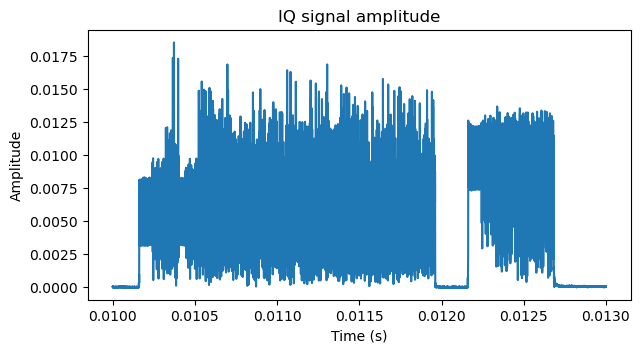

In [12]:
sel = slice(40000, 52000)
plt.plot(np.arange(x.size)[sel] / fs, np.abs(x[sel]))
plt.title('IQ signal amplitude')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)');

In [13]:
stf_corr_complex = np.convolve(x[Tu//4:] * np.conjugate(x[:-Tu//4]), np.ones(2 * Ts - Tu//4))

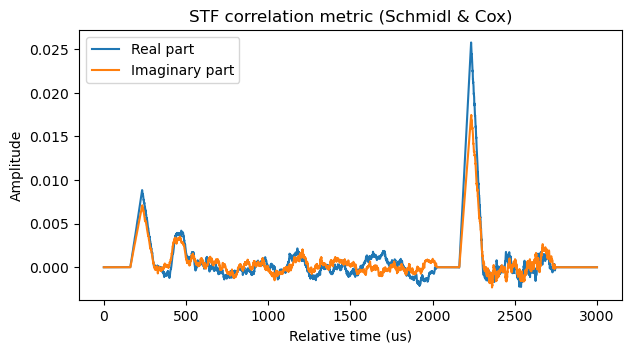

In [14]:
sel = slice(40000, 52000)
tax = np.arange(stf_corr_complex[sel].size) / fs * 1e6
plt.plot(tax, stf_corr_complex.real[sel], label='Real part')
plt.plot(tax, stf_corr_complex.imag[sel], label='Imaginary part')
plt.legend()
plt.title('STF correlation metric (Schmidl & Cox)')
plt.ylabel('Amplitude')
plt.xlabel('Relative time (us)');

In [15]:
stf_corr = np.abs(stf_corr_complex)
del stf_corr_complex

In [16]:
detect_window = 6 * Ts
norm_window = (-Ts, -Ts//2)
local_maxima_window = (-2*Ts, 2*Ts)
stf_corr_w = stf_corr[:stf_corr.size//detect_window*detect_window].reshape(-1, detect_window)
max_value_norm = np.empty(stf_corr_w.shape[0])
max_idx = np.empty(stf_corr_w.shape[0], 'int')
for j in range(max_idx.size):
    a = np.argmax(stf_corr_w[j])
    max_idx[j] = a + j * detect_window - (2 * Ts - Tu//4 - 1)
    norm = np.average(np.abs(x[max_idx[j] + norm_window[0]:max_idx[j] + norm_window[1]])**2)
    max_value_norm[j] = stf_corr_w[j, a] / norm
    b = j * detect_window + a
    local_maxima = stf_corr_w[j, a] >= np.max(stf_corr[b + local_maxima_window[0]:b + local_maxima_window[1]])
    if not local_maxima:
        max_value_norm[j] = np.nan

threshold_dB = 30
detections = max_value_norm >= 10**(threshold_dB/10)
# Remove these detections manually, since they are false detections
# that cause a correct SIG CRC by chance and trigger some unsopported features
# assertions
detections[np.where(detections)[0][1938]] = False
detections[np.where(detections)[0][2243]] = False

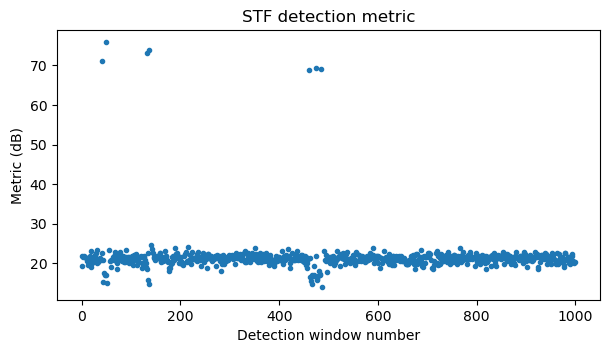

In [17]:
plt.plot(10*np.log10(max_value_norm[:1000]), '.')
plt.title('STF detection metric')
plt.xlabel('Detection window number')
plt.ylabel('Metric (dB)');

PPDU 0 at sample 40645
-----------------------------
Coarse CFO: 13403.859 Hz
Fine CFO: -47.516 Hz
Total CFO: 13356.343 Hz
Coarse STO: 0.00 samples
Fine STO: 0.877 samples
Total STO: 0.877 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 36
response indication = 2
traveling pilots = 1

noise sigma = 0.036
BER = 0.0

PPDU 1 at sample 48649
-----------------------------
Coarse CFO: 11811.384 Hz
Fine CFO: 34.494 Hz
Total CFO: 11845.878 Hz
Coarse STO: 0.00 samples
Fine STO: 0.545 samples
Total STO: 0.545 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.127
BER = 0.0

PPDU 2 at sample 127716
--------------

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 11087798)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0019230769230769232

PPDU 213 at sample 11097370
-----------------------------
Coarse CFO: 13407.540 Hz
Fine CFO: -8.078 Hz
Total CFO: 13399.461 Hz
Coarse STO: 0.00 samples
Fine STO: 0.669 samples
Total STO: 0.669 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.035
BER = 0.0

PPDU 214 at sample 11102262
-----------------------------
Coarse CFO: 13429.654 Hz
Fine CFO: -47.622 Hz
Total CFO: 13382.032 Hz
Coarse STO: 0.00 samples
Fine STO: 0.593 samples
Total STO: 0.593 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 1

noise sigma = 0.037
BER = 0.0



/tmp/ipykernel_90718/3422983186.py:527: UserWarning: MPDU delimiter reserved bit wrong (start_idx = 19108780)
  warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 19108780)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


noise sigma = 0.099
BER = 0.0004807692307692308

PPDU 317 at sample 19121266
-----------------------------
Coarse CFO: 13413.800 Hz
Fine CFO: -19.693 Hz
Total CFO: 13394.107 Hz
Coarse STO: 0.00 samples
Fine STO: 0.339 samples
Total STO: 0.339 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.033
BER = 0.0

PPDU 318 at sample 19266599
-----------------------------
Coarse CFO: 13438.932 Hz
Fine CFO: -30.941 Hz
Total CFO: 13407.992 Hz
Coarse STO: 0.00 samples
Fine STO: 1.085 samples
Total STO: 1.085 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 26
response indication = 2
traveling pilots = 1

noise sig

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 24781802)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0019796380090497737

PPDU 417 at sample 24794438
-----------------------------
Coarse CFO: 13445.971 Hz
Fine CFO: -46.350 Hz
Total CFO: 13399.621 Hz
Coarse STO: 0.00 samples
Fine STO: 0.430 samples
Total STO: 0.430 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.029
BER = 0.0

PPDU 418 at sample 24878748
-----------------------------
Coarse CFO: 13449.662 Hz
Fine CFO: -25.714 Hz
Total CFO: 13423.948 Hz
Coarse STO: 0.00 samples
Fine STO: 1.125 samples
Total STO: 1.125 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 49
response indication = 2
traveling pilots = 1

noise sigma = 0.033
BER = 0.0

/tmp/ipykernel_90718/3422983186.py:527: UserWarning: MPDU delimiter reserved bit wrong (start_idx = 31147547)
  warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 31147547)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


noise sigma = 0.040
BER = 0.0013354700854700855

PPDU 517 at sample 31170838
-----------------------------
Coarse CFO: 11833.442 Hz
Fine CFO: 50.228 Hz
Total CFO: 11883.670 Hz
Coarse STO: 0.00 samples
Fine STO: 0.388 samples
Total STO: 0.388 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.106
BER = 0.0

PPDU 518 at sample 31187294
-----------------------------
Coarse CFO: 11847.012 Hz
Fine CFO: 36.340 Hz
Total CFO: 11883.352 Hz
Coarse STO: 0.00 samples
Fine STO: 0.164 samples
Total STO: 0.164 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 6
response indication = 2
traveling pilots = 1

noise sigma 

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 33541622)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0004807692307692308

PPDU 554 at sample 33553202
-----------------------------
Coarse CFO: 13399.629 Hz
Fine CFO: -45.258 Hz
Total CFO: 13354.371 Hz
Coarse STO: 0.00 samples
Fine STO: 0.681 samples
Total STO: 0.681 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.036
BER = 0.0

PPDU 555 at sample 33560710
-----------------------------
Coarse CFO: 13423.279 Hz
Fine CFO: -9.209 Hz
Total CFO: 13414.070 Hz
Coarse STO: 0.00 samples
Fine STO: 0.564 samples
Total STO: 0.564 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 1

noise sigma = 0.027
BER = 0.0



/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 34968273)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0

PPDU 581 at sample 35048444
-----------------------------
Coarse CFO: 11854.093 Hz
Fine CFO: 53.624 Hz
Total CFO: 11907.717 Hz
Coarse STO: 0.00 samples
Fine STO: 1.114 samples
Total STO: 1.114 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.122
BER = 0.0

PPDU 582 at sample 35227290
-----------------------------
Coarse CFO: 11875.658 Hz
Fine CFO: 24.585 Hz
Total CFO: 11900.243 Hz
Coarse STO: 0.00 samples
Fine STO: 0.656 samples
Total STO: 0.656 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 6
response indication = 2
traveling pilots = 1

noise sigma = 0.104
BER = 0.0008012820512820513

P

/tmp/ipykernel_90718/3422983186.py:537: UserWarning: MPDU delimiter CRC error (start_idx = 37948609)
  warnings.warn(f'MPDU delimiter CRC error (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 37948609)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


noise sigma = 0.035
BER = 0.00017806267806267807

PPDU 622 at sample 37977268
-----------------------------
Coarse CFO: 11878.316 Hz
Fine CFO: 54.215 Hz
Total CFO: 11932.532 Hz
Coarse STO: 0.00 samples
Fine STO: 0.862 samples
Total STO: 0.862 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.113
BER = 0.0

PPDU 623 at sample 38227445
-----------------------------
Coarse CFO: 11872.637 Hz
Fine CFO: 61.797 Hz
Total CFO: 11934.434 Hz
Coarse STO: 0.00 samples
Fine STO: 0.427 samples
Total STO: 0.427 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 6
response indication = 2
traveling pilots = 1

noise sigma

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 48698320)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0

PPDU 797 at sample 48723632
-----------------------------
Coarse CFO: 11878.194 Hz
Fine CFO: 23.127 Hz
Total CFO: 11901.322 Hz
Coarse STO: 0.00 samples
Fine STO: 1.120 samples
Total STO: 1.120 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.164
BER = 0.0

PPDU 798 at sample 48934810
-----------------------------
Coarse CFO: 11871.343 Hz
Fine CFO: 76.477 Hz
Total CFO: 11947.820 Hz
Coarse STO: 0.00 samples
Fine STO: 0.228 samples
Total STO: 0.228 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 2 (QPSK 3/4)
smoothing = 0
aggregation = 0
length = 112 (N_sym = 12)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.143
BER = 0.0

PPDU 799 at s

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 50864135)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0009157509157509158

PPDU 818 at sample 50948590
-----------------------------
Coarse CFO: 11917.991 Hz
Fine CFO: 29.197 Hz
Total CFO: 11947.188 Hz
Coarse STO: 0.00 samples
Fine STO: 0.547 samples
Total STO: 0.547 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.117
BER = 0.0

PPDU 819 at sample 50954006
-----------------------------
Coarse CFO: 11894.438 Hz
Fine CFO: 43.232 Hz
Total CFO: 11937.671 Hz
Coarse STO: 0.00 samples
Fine STO: 0.477 samples
Total STO: 0.477 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 6
response indication = 2
traveling pilots = 1

noise sigma = 0.104
BER = 0.0

P

/tmp/ipykernel_90718/3422983186.py:516: UserWarning: reserved bit in SERVICE is not zero
  warnings.warn('reserved bit in SERVICE is not zero')
/tmp/ipykernel_90718/3422983186.py:537: UserWarning: MPDU delimiter CRC error (start_idx = 51969901)
  warnings.warn(f'MPDU delimiter CRC error (start_idx = {start_idx})')


BER = 0.0

PPDU 835 at sample 51989524
-----------------------------
Coarse CFO: 13434.754 Hz
Fine CFO: -33.040 Hz
Total CFO: 13401.713 Hz
Coarse STO: 0.00 samples
Fine STO: 1.009 samples
Total STO: 1.009 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.033
BER = 0.0

PPDU 836 at sample 51995800
-----------------------------
Coarse CFO: 13425.734 Hz
Fine CFO: -21.319 Hz
Total CFO: 13404.414 Hz
Coarse STO: 0.00 samples
Fine STO: 0.910 samples
Total STO: 0.910 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 6 (64-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 28
response indication = 2
traveling pilots = 1

noise sigma = 0.038
BER = 0.0002289377289377289

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 57401050)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0

PPDU 952 at sample 58007081
-----------------------------
Coarse CFO: 11861.767 Hz
Fine CFO: 58.547 Hz
Total CFO: 11920.314 Hz
Coarse STO: 0.00 samples
Fine STO: 0.449 samples
Total STO: 0.449 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 7
response indication = 2
traveling pilots = 1

noise sigma = 0.117
BER = 0.0006868131868131869

PPDU 953 at sample 58010447
-----------------------------
Coarse CFO: 13441.678 Hz
Fine CFO: -68.683 Hz
Total CFO: 13372.995 Hz
Coarse STO: 0.00 samples
Fine STO: 0.468 samples
Total STO: 0.468 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.035
BER = 0.0



/tmp/ipykernel_90718/3422983186.py:541: UserWarning: MPDU delimiter signature wrong (start_idx = 66311131)
  warnings.warn(f'MPDU delimiter signature wrong (start_idx = {start_idx})')


BER = 0.0

PPDU 1061 at sample 66433168
-----------------------------
Coarse CFO: 13430.670 Hz
Fine CFO: -34.895 Hz
Total CFO: 13395.775 Hz
Coarse STO: 0.00 samples
Fine STO: 0.817 samples
Total STO: 0.817 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.026
BER = 0.0

PPDU 1062 at sample 66558426
-----------------------------
Coarse CFO: 13429.536 Hz
Fine CFO: -15.488 Hz
Total CFO: 13414.048 Hz
Coarse STO: 0.00 samples
Fine STO: 0.871 samples
Total STO: 0.871 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 6 (64-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 47
response indication = 2
traveling pilots = 1

noise sigma = 0.035
BER = 0.00013638843426077

/tmp/ipykernel_90718/3422983186.py:537: UserWarning: MPDU delimiter CRC error (start_idx = 82350898)
  warnings.warn(f'MPDU delimiter CRC error (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 82350898)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


noise sigma = 0.091
BER = 0.0005341880341880342

PPDU 1286 at sample 82360241
-----------------------------
Coarse CFO: 13434.417 Hz
Fine CFO: -42.698 Hz
Total CFO: 13391.720 Hz
Coarse STO: 0.00 samples
Fine STO: 0.754 samples
Total STO: 0.754 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.032
BER = 0.0

PPDU 1287 at sample 82366285
-----------------------------
Coarse CFO: 13454.805 Hz
Fine CFO: -50.036 Hz
Total CFO: 13404.769 Hz
Coarse STO: 0.00 samples
Fine STO: 0.662 samples
Total STO: 0.662 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 6 (64-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 28
response indication = 2
traveling pilots = 1

noise s

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 88611925)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0008932324506094998

PPDU 1399 at sample 88639203
-----------------------------
Coarse CFO: 11909.457 Hz
Fine CFO: 45.732 Hz
Total CFO: 11955.189 Hz
Coarse STO: 0.00 samples
Fine STO: 0.673 samples
Total STO: 0.673 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.135
BER = 0.0

PPDU 1400 at sample 88646280
-----------------------------
Coarse CFO: 13464.987 Hz
Fine CFO: -39.485 Hz
Total CFO: 13425.502 Hz
Coarse STO: 0.00 samples
Fine STO: 0.238 samples
Total STO: 0.238 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.032
BER = 0.0

PPDU 14

/tmp/ipykernel_90718/3422983186.py:537: UserWarning: MPDU delimiter CRC error (start_idx = 88936132)
  warnings.warn(f'MPDU delimiter CRC error (start_idx = {start_idx})')


BER = 0.00010508617065994115

PPDU 1428 at sample 88960131
-----------------------------
Coarse CFO: 11853.861 Hz
Fine CFO: 66.368 Hz
Total CFO: 11920.229 Hz
Coarse STO: 0.00 samples
Fine STO: 0.254 samples
Total STO: 0.254 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.118
BER = 0.0

PPDU 1429 at sample 88964499
-----------------------------
Coarse CFO: 11899.874 Hz
Fine CFO: 48.683 Hz
Total CFO: 11948.557 Hz
Coarse STO: 0.00 samples
Fine STO: 0.198 samples
Total STO: 0.198 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 3 (16-QAM 1/2)
beam change / smoothing = 0
aggregation = 1
length = 17
response indication = 2
traveling pilots = 1

noise sigma = 0.111
BER = 0.

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 105075300)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


noise sigma = 0.028
BER = 0.0

PPDU 1697 at sample 105430003
-----------------------------
Coarse CFO: 13445.442 Hz
Fine CFO: -35.843 Hz
Total CFO: 13409.598 Hz
Coarse STO: 0.00 samples
Fine STO: 0.686 samples
Total STO: 0.686 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 49
response indication = 2
traveling pilots = 1

noise sigma = 0.033
BER = 0.0

PPDU 1698 at sample 105440087
-----------------------------
Coarse CFO: 11893.258 Hz
Fine CFO: 33.018 Hz
Total CFO: 11926.275 Hz
Coarse STO: 0.00 samples
Fine STO: 1.065 samples
Total STO: 1.065 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.123
BER 

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 107030971)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 5.935422602089269e-05

PPDU 1726 at sample 107062421
-----------------------------
Coarse CFO: 11951.121 Hz
Fine CFO: 9.921 Hz
Total CFO: 11961.041 Hz
Coarse STO: 0.00 samples
Fine STO: 0.689 samples
Total STO: 0.689 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.123
BER = 0.0

PPDU 1727 at sample 107075037
-----------------------------
Coarse CFO: 11893.293 Hz
Fine CFO: 42.534 Hz
Total CFO: 11935.827 Hz
Coarse STO: 0.00 samples
Fine STO: 0.514 samples
Total STO: 0.514 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 6
response indication = 2
traveling pilots = 1

noise sigma = 0.110
BER = 0.0

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 109468921)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 7.284382284382284e-05

PPDU 1772 at sample 109493620
-----------------------------
Coarse CFO: 11911.985 Hz
Fine CFO: 15.539 Hz
Total CFO: 11927.523 Hz
Coarse STO: 0.00 samples
Fine STO: 0.162 samples
Total STO: 0.162 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.120
BER = 0.0

PPDU 1773 at sample 109541123
-----------------------------
Coarse CFO: 11912.138 Hz
Fine CFO: 10.362 Hz
Total CFO: 11922.500 Hz
Coarse STO: 0.00 samples
Fine STO: 0.512 samples
Total STO: 0.512 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 6
response indication = 2
traveling pilots = 1

noise sigma = 0.107
BER = 0.

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 109549460)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0008333333333333334

PPDU 1779 at sample 109590078
-----------------------------
Coarse CFO: 13487.405 Hz
Fine CFO: -78.062 Hz
Total CFO: 13409.343 Hz
Coarse STO: 0.00 samples
Fine STO: 1.071 samples
Total STO: 1.071 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.037
BER = 0.0

PPDU 1780 at sample 109592482
-----------------------------
Coarse CFO: 11950.842 Hz
Fine CFO: -3.874 Hz
Total CFO: 11946.968 Hz
Coarse STO: 0.00 samples
Fine STO: 0.794 samples
Total STO: 0.794 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 20 (N_sym = 4)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.102
BER = 0.0

PPDU 

/tmp/ipykernel_90718/3422983186.py:537: UserWarning: MPDU delimiter CRC error (start_idx = 111148473)
  warnings.warn(f'MPDU delimiter CRC error (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 111148473)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0

PPDU 1809 at sample 111171500
-----------------------------
Coarse CFO: 11901.335 Hz
Fine CFO: 23.331 Hz
Total CFO: 11924.666 Hz
Coarse STO: 0.00 samples
Fine STO: 1.026 samples
Total STO: 1.026 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 7
response indication = 2
traveling pilots = 1

noise sigma = 0.095
BER = 0.0013736263736263737

PPDU 1810 at sample 111174866
-----------------------------
Coarse CFO: 13463.862 Hz
Fine CFO: -38.135 Hz
Total CFO: 13425.727 Hz
Coarse STO: 0.00 samples
Fine STO: 0.451 samples
Total STO: 0.451 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.030
BER = 0

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 116275628)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


noise sigma = 0.026
BER = 0.0

PPDU 1888 at sample 116459008
-----------------------------
Coarse CFO: 13466.981 Hz
Fine CFO: -34.923 Hz
Total CFO: 13432.058 Hz
Coarse STO: 0.00 samples
Fine STO: 0.328 samples
Total STO: 0.328 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 26
response indication = 2
traveling pilots = 1

noise sigma = 0.032
BER = 0.0001232741617357002

PPDU 1889 at sample 116465411
-----------------------------
Coarse CFO: 11969.982 Hz
Fine CFO: 16.035 Hz
Total CFO: 11986.017 Hz
Coarse STO: 0.00 samples
Fine STO: 0.980 samples
Total STO: 0.980 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise 

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 117991186)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


noise sigma = 0.033
BER = 0.0

PPDU 1930 at sample 118462764
-----------------------------
Coarse CFO: 13523.451 Hz
Fine CFO: -51.113 Hz
Total CFO: 13472.338 Hz
Coarse STO: 0.00 samples
Fine STO: 1.179 samples
Total STO: 1.179 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 36
response indication = 2
traveling pilots = 1

noise sigma = 0.049
BER = 0.0011574074074074073

PPDU 1931 at sample 118479572
-----------------------------
Coarse CFO: 13479.795 Hz
Fine CFO: -46.621 Hz
Total CFO: 13433.174 Hz
Coarse STO: 0.00 samples
Fine STO: 0.916 samples
Total STO: 0.916 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 6 (64-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 40
response indication = 2
traveling pilots = 1

noise si

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 118670989)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.041666666666666664

PPDU 1943 at sample 119448453
-----------------------------
Coarse CFO: 13494.419 Hz
Fine CFO: -51.287 Hz
Total CFO: 13443.131 Hz
Coarse STO: 0.00 samples
Fine STO: 0.859 samples
Total STO: 0.859 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.025
BER = 0.0

PPDU 1944 at sample 119453661
-----------------------------
Coarse CFO: 13484.343 Hz
Fine CFO: -39.875 Hz
Total CFO: 13444.468 Hz
Coarse STO: 0.00 samples
Fine STO: 0.778 samples
Total STO: 0.778 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.034
BER = 0.0

PPDU 

/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 123486819)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0

PPDU 2057 at sample 123522158
-----------------------------
Coarse CFO: 13461.240 Hz
Fine CFO: -14.753 Hz
Total CFO: 13446.487 Hz
Coarse STO: 0.00 samples
Fine STO: 0.545 samples
Total STO: 0.545 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 6 (64-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 36
response indication = 2
traveling pilots = 1

noise sigma = 0.030
BER = 8.903133903133904e-05

PPDU 2058 at sample 123530162
-----------------------------
Coarse CFO: 11947.624 Hz
Fine CFO: 45.348 Hz
Total CFO: 11992.972 Hz
Coarse STO: 0.00 samples
Fine STO: 0.519 samples
Total STO: 0.519 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.119
BER = 

/tmp/ipykernel_90718/3422983186.py:527: UserWarning: MPDU delimiter reserved bit wrong (start_idx = 130526486)
  warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 130526486)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0010683760683760685

PPDU 2203 at sample 130540021
-----------------------------
Coarse CFO: 11872.630 Hz
Fine CFO: 74.318 Hz
Total CFO: 11946.948 Hz
Coarse STO: 0.00 samples
Fine STO: 0.605 samples
Total STO: 0.605 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 1
coding = BCC
LDPC extra = 1
MCS = 2 (QPSK 3/4)
beam change / smoothing = 0
aggregation = 1
length = 12
response indication = 2
traveling pilots = 1

noise sigma = 0.120
BER = 0.0

PPDU 2204 at sample 130544017
-----------------------------
Coarse CFO: 13510.990 Hz
Fine CFO: -39.432 Hz
Total CFO: 13471.558 Hz
Coarse STO: 0.00 samples
Fine STO: 0.235 samples
Total STO: 0.235 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.033
BER = 0.

/tmp/ipykernel_90718/3422983186.py:527: UserWarning: MPDU delimiter reserved bit wrong (start_idx = 130770963)
  warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 130770963)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


BER = 0.0

PPDU 2216 at sample 130799553
-----------------------------
Coarse CFO: 11907.356 Hz
Fine CFO: 60.720 Hz
Total CFO: 11968.076 Hz
Coarse STO: 2.46 samples
Fine STO: -0.817 samples
Total STO: 1.644 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.172
BER = 0.0013736263736263737

PPDU 2217 at sample 130853689
-----------------------------
Coarse CFO: 11916.192 Hz
Fine CFO: 47.090 Hz
Total CFO: 11963.282 Hz
Coarse STO: 0.00 samples
Fine STO: 0.807 samples
Total STO: 0.807 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 2 (QPSK 3/4)
smoothing = 0
aggregation = 0
length = 112 (N_sym = 12)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.158
B

/tmp/ipykernel_90718/3422983186.py:527: UserWarning: MPDU delimiter reserved bit wrong (start_idx = 131489676)
  warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')


BER = 0.0

PPDU 2224 at sample 131501110
-----------------------------
Coarse CFO: 13540.159 Hz
Fine CFO: -40.715 Hz
Total CFO: 13499.443 Hz
Coarse STO: 0.00 samples
Fine STO: 0.315 samples
Total STO: 0.315 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 46
response indication = 2
traveling pilots = 1

noise sigma = 0.045
BER = 0.0

PPDU 2225 at sample 131510715
-----------------------------
Coarse CFO: 11784.394 Hz
Fine CFO: 368.971 Hz
Total CFO: 12153.364 Hz
Coarse STO: 0.00 samples
Fine STO: 0.203 samples
Total STO: 0.203 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.213
BER = 0.009615384615384

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 131546924)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0

PPDU 2232 at sample 131883043
-----------------------------
Coarse CFO: 11894.670 Hz
Fine CFO: 42.589 Hz
Total CFO: 11937.260 Hz
Coarse STO: 0.00 samples
Fine STO: 0.132 samples
Total STO: 0.132 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.129
BER = 0.0

PPDU 2233 at sample 132092708
-----------------------------
Coarse CFO: 11916.941 Hz
Fine CFO: 24.114 Hz
Total CFO: 11941.055 Hz
Coarse STO: 0.00 samples
Fine STO: 0.315 samples
Total STO: 0.315 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 7
response indication = 2
traveling pilots = 1

noise sigma = 0.103
BER = 0.000686813186813186

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 132238362)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0

PPDU 2238 at sample 132264986
-----------------------------
Coarse CFO: 13522.246 Hz
Fine CFO: -23.000 Hz
Total CFO: 13499.246 Hz
Coarse STO: 0.00 samples
Fine STO: 0.407 samples
Total STO: 0.407 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 43
response indication = 2
traveling pilots = 1

noise sigma = 0.033
BER = 0.0

PPDU 2239 at sample 132274109
-----------------------------
Coarse CFO: 11972.107 Hz
Fine CFO: 27.232 Hz
Total CFO: 11999.339 Hz
Coarse STO: 0.00 samples
Fine STO: 0.821 samples
Total STO: 0.821 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.146
BER = 0.0

PPDU 2240 at 

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 132314900)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


noise sigma = 0.032
BER = 0.0

PPDU 2243 at sample 132666127
-----------------------------
Coarse CFO: 13528.803 Hz
Fine CFO: -53.402 Hz
Total CFO: 13475.401 Hz
Coarse STO: 0.00 samples
Fine STO: 1.155 samples
Total STO: 1.155 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.032
BER = 0.0

PPDU 2244 at sample 132668532
-----------------------------
Coarse CFO: 11880.385 Hz
Fine CFO: 67.198 Hz
Total CFO: 11947.584 Hz
Coarse STO: 0.00 samples
Fine STO: 0.398 samples
Total STO: 0.398 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 20 (N_sym = 4)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.116
BER = 0.0

PPD

/tmp/ipykernel_90718/3422983186.py:527: UserWarning: MPDU delimiter reserved bit wrong (start_idx = 137060020)
  warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')


BER = 0.002692307692307692

PPDU 2347 at sample 137074183
-----------------------------
Coarse CFO: 13472.098 Hz
Fine CFO: -51.216 Hz
Total CFO: 13420.883 Hz
Coarse STO: 0.00 samples
Fine STO: 0.448 samples
Total STO: 0.448 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.031
BER = 0.0

PPDU 2348 at sample 137080807
-----------------------------
Coarse CFO: 13492.740 Hz
Fine CFO: -28.924 Hz
Total CFO: 13463.815 Hz
Coarse STO: 0.00 samples
Fine STO: 0.347 samples
Total STO: 0.347 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.033
BER = 0.0

PPDU 

/tmp/ipykernel_90718/3422983186.py:527: UserWarning: MPDU delimiter reserved bit wrong (start_idx = 137535949)
  warnings.warn(f'MPDU delimiter reserved bit wrong (start_idx = {start_idx})')


BER = 0.0016025641025641025

PPDU 2374 at sample 137547603
-----------------------------
Coarse CFO: 13507.256 Hz
Fine CFO: -39.588 Hz
Total CFO: 13467.669 Hz
Coarse STO: 0.00 samples
Fine STO: 1.071 samples
Total STO: 1.071 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.030
BER = 0.0

PPDU 2375 at sample 137551960
-----------------------------
Coarse CFO: 11906.744 Hz
Fine CFO: 55.640 Hz
Total CFO: 11962.384 Hz
Coarse STO: 0.00 samples
Fine STO: 0.982 samples
Total STO: 0.982 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 6
response indication = 2
traveling pilots = 1

noise sigma = 0.133
BER = 0

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 138770530)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG (start_idx = 139170791)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')



SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.035
BER = 0.0

PPDU 2397 at sample 139482118
-----------------------------
Coarse CFO: 11924.059 Hz
Fine CFO: 50.668 Hz
Total CFO: 11974.727 Hz
Coarse STO: 0.00 samples
Fine STO: 0.315 samples
Total STO: 0.315 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 20 (N_sym = 4)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.119
BER = 0.0

PPDU 2398 at sample 139484521
-----------------------------
Coarse CFO: 13520.209 Hz
Fine CFO: -25.062 Hz
Total CFO: 13495.147 Hz
Coarse STO: 0.00 samples
Fine STO: 0.894 samples
Total STO: 0.894 samples

SIG-A contents
MU/SU = 0
STBC = 0

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 140858764)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0

PPDU 2429 at sample 141486738
-----------------------------
Coarse CFO: 11848.822 Hz
Fine CFO: 94.865 Hz
Total CFO: 11943.686 Hz
Coarse STO: 0.00 samples
Fine STO: 0.641 samples
Total STO: 0.641 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 20 (N_sym = 4)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.106
BER = 0.0

PPDU 2430 at sample 141489142
-----------------------------
Coarse CFO: 13507.776 Hz
Fine CFO: -36.921 Hz
Total CFO: 13470.855 Hz
Coarse STO: 0.00 samples
Fine STO: 0.645 samples
Total STO: 0.645 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 81
response indication = 2
traveling pilots = 1

noise sigma = 0.036
BER = 0.0

PPDU 2431 at 

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 141550752)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


noise sigma = 0.034
BER = 0.0

PPDU 2439 at sample 141884992
-----------------------------
Coarse CFO: 13554.579 Hz
Fine CFO: -17.875 Hz
Total CFO: 13536.705 Hz
Coarse STO: 0.00 samples
Fine STO: 0.470 samples
Total STO: 0.470 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 4 (16-QAM 3/4)
beam change / smoothing = 0
aggregation = 1
length = 49
response indication = 2
traveling pilots = 1

noise sigma = 0.095
BER = 0.0003924646781789639

PPDU 2440 at sample 141895076
-----------------------------
Coarse CFO: 11953.498 Hz
Fine CFO: 29.645 Hz
Total CFO: 11983.143 Hz
Coarse STO: 0.00 samples
Fine STO: 1.004 samples
Total STO: 1.004 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise 

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 142062483)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0

PPDU 2443 at sample 142089993
-----------------------------
Coarse CFO: 13525.452 Hz
Fine CFO: -40.910 Hz
Total CFO: 13484.543 Hz
Coarse STO: 0.00 samples
Fine STO: 0.273 samples
Total STO: 0.273 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.033
BER = 0.0

PPDU 2444 at sample 142182450
-----------------------------
Coarse CFO: -18113.451 Hz
Fine CFO: 11915.324 Hz
Total CFO: -6198.127 Hz
Coarse STO: -4.92 samples
Fine STO: 0.082 samples
Total STO: -4.841 samples

PPDU 2445 at sample 142241262
-----------------------------
Coarse CFO: 13517.830 Hz
Fine CFO: -22.135 Hz
Total CFO: 13495.694 Hz
Coarse STO: 0.00 samples
Fine STO: 0.910 samples
Total STO: 0.910 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x1

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 142182445)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0

PPDU 2447 at sample 142284582
-----------------------------
Coarse CFO: 13569.386 Hz
Fine CFO: -54.538 Hz
Total CFO: 13514.848 Hz
Coarse STO: 0.00 samples
Fine STO: 0.236 samples
Total STO: 0.236 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.036
BER = 0.0

PPDU 2448 at sample 142286987
-----------------------------
Coarse CFO: 11896.586 Hz
Fine CFO: 70.868 Hz
Total CFO: 11967.454 Hz
Coarse STO: 0.00 samples
Fine STO: 0.578 samples
Total STO: 0.578 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 20 (N_sym = 4)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.096
BER = 0.0

PPDU 2449 at sample 142

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 142634724)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.0

PPDU 2462 at sample 142697221
-----------------------------
Coarse CFO: 11904.262 Hz
Fine CFO: 62.410 Hz
Total CFO: 11966.672 Hz
Coarse STO: 0.00 samples
Fine STO: 0.917 samples
Total STO: 0.917 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.126
BER = 0.0

PPDU 2463 at sample 143087484
-----------------------------
Coarse CFO: 11945.456 Hz
Fine CFO: 28.689 Hz
Total CFO: 11974.145 Hz
Coarse STO: 0.00 samples
Fine STO: 0.530 samples
Total STO: 0.530 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 9
response indication = 0
traveling pilots = 1
NDP indication = 0

noise sigma = 0.200
BER = 0.0

PPDU 2464 at sample 1431

/tmp/ipykernel_90718/3422983186.py:537: UserWarning: MPDU delimiter CRC error (start_idx = 143570030)
  warnings.warn(f'MPDU delimiter CRC error (start_idx = {start_idx})')


BER = 0.0

PPDU 2478 at sample 143594457
-----------------------------
Coarse CFO: 11901.248 Hz
Fine CFO: 65.781 Hz
Total CFO: 11967.029 Hz
Coarse STO: 0.00 samples
Fine STO: 0.517 samples
Total STO: 0.517 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.136
BER = 0.0

PPDU 2479 at sample 143600005
-----------------------------
Coarse CFO: 11896.492 Hz
Fine CFO: 34.766 Hz
Total CFO: 11931.258 Hz
Coarse STO: 0.00 samples
Fine STO: 0.445 samples
Total STO: 0.445 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 5 (64-QAM 2/3)
beam change / smoothing = 0
aggregation = 1
length = 5
response indication = 2
traveling pilots = 1

noise sigma = 0.099
BER = 0.03974358974358974


/tmp/ipykernel_90718/3422983186.py:541: UserWarning: MPDU delimiter signature wrong (start_idx = 144869216)
  warnings.warn(f'MPDU delimiter signature wrong (start_idx = {start_idx})')


BER = 0.0

PPDU 2529 at sample 144887509
-----------------------------
Coarse CFO: 13535.695 Hz
Fine CFO: -57.246 Hz
Total CFO: 13478.449 Hz
Coarse STO: 0.00 samples
Fine STO: 0.601 samples
Total STO: 0.601 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.028
BER = 0.0

PPDU 2530 at sample 144990682
-----------------------------
Coarse CFO: -50712.208 Hz
Fine CFO: 8484.763 Hz
Total CFO: -42227.445 Hz
Coarse STO: 12.31 samples
Fine STO: -0.516 samples
Total STO: 11.792 samples

PPDU 2531 at sample 145062430
-----------------------------
Coarse CFO: 57214.016 Hz
Fine CFO: 8435.294 Hz
Total CFO: 65649.311 Hz
Coarse STO: 2.46 samples
Fine STO: -0.154 samples
Total STO: 2.307 samples

PPDU 2532 at sample 145094898
-----------------------------
Coarse CFO: 13559.685

/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 144990694)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')
/tmp/ipykernel_90718/3422983186.py:127: UserWarning: failed to decoded SIG-A (start_idx = 145062432)
  warnings.warn(f'failed to decoded {sig_name} (start_idx = {start_idx})')


BER = 0.00017806267806267807

PPDU 2535 at sample 145120845
-----------------------------
Coarse CFO: 13535.494 Hz
Fine CFO: -46.187 Hz
Total CFO: 13489.307 Hz
Coarse STO: 0.00 samples
Fine STO: 0.955 samples
Total STO: 0.955 samples

SIG contents
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x000
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 0
NDP indication = 0

noise sigma = 0.031
BER = 0.0

PPDU 2536 at sample 145123252
-----------------------------
Coarse CFO: 11923.146 Hz
Fine CFO: 29.159 Hz
Total CFO: 11952.305 Hz
Coarse STO: 0.00 samples
Fine STO: 0.431 samples
Total STO: 0.431 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 20 (N_sym = 4)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.122
BER = 0.0

PPDU

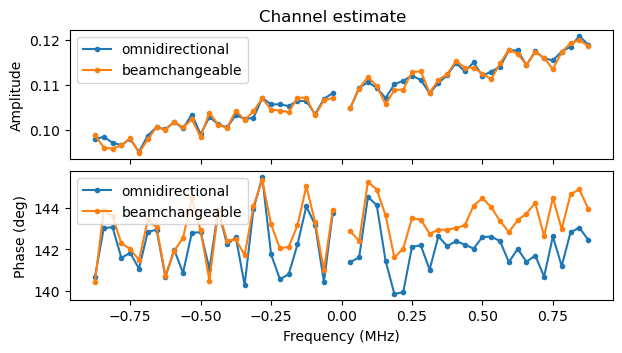

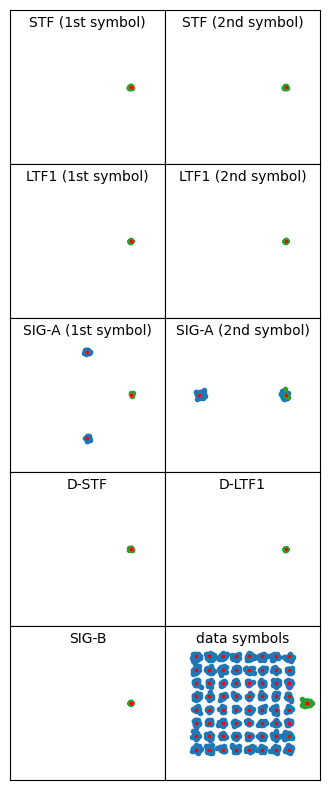

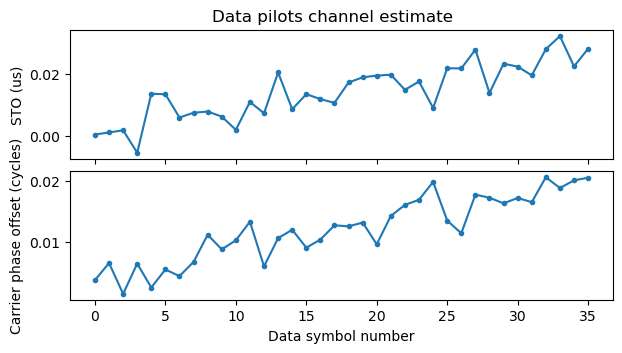

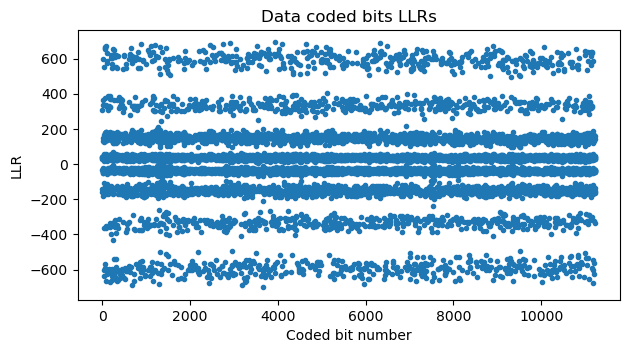

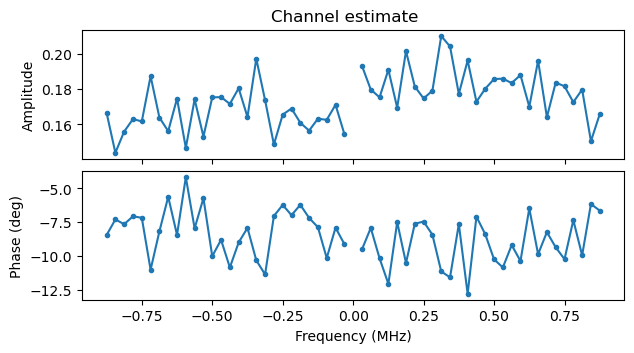

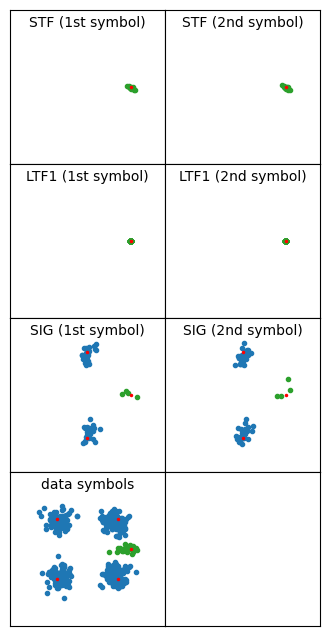

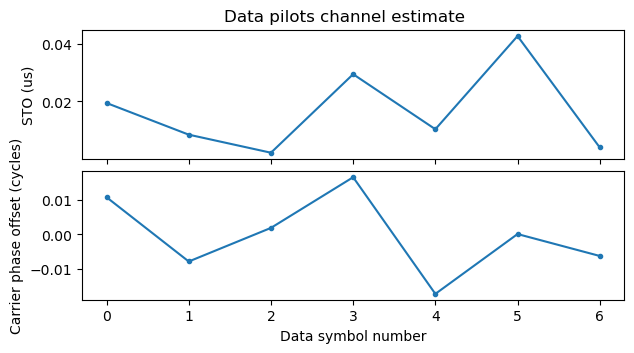

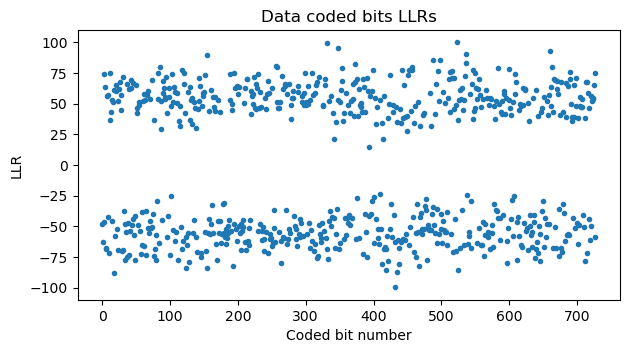

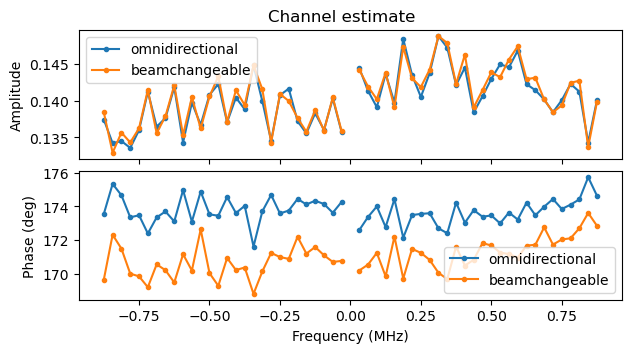

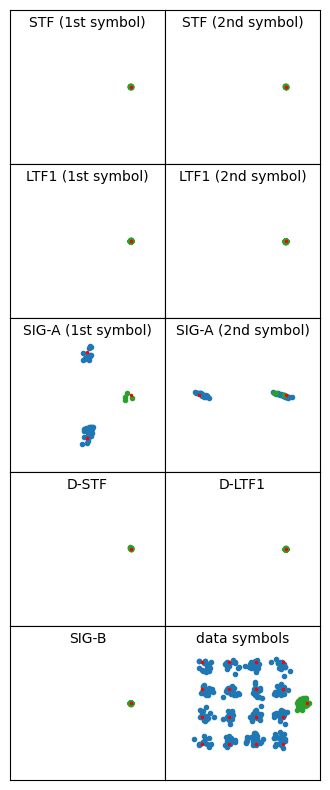

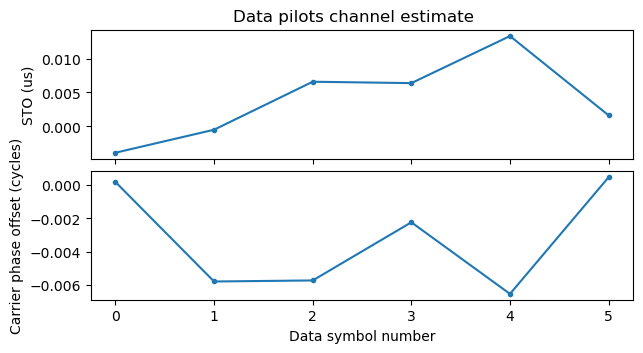

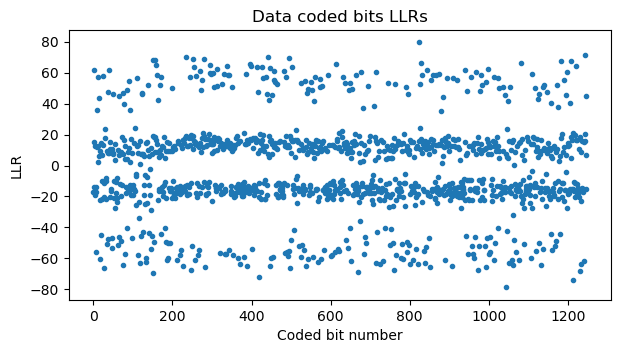

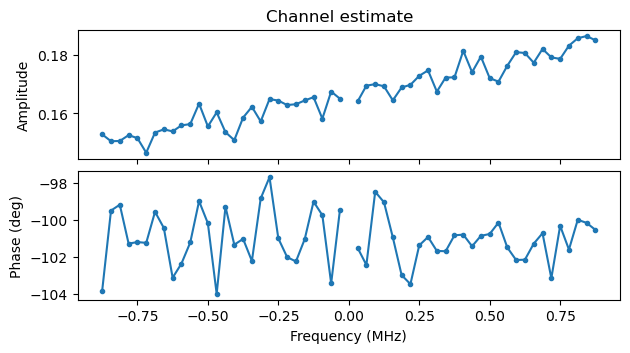

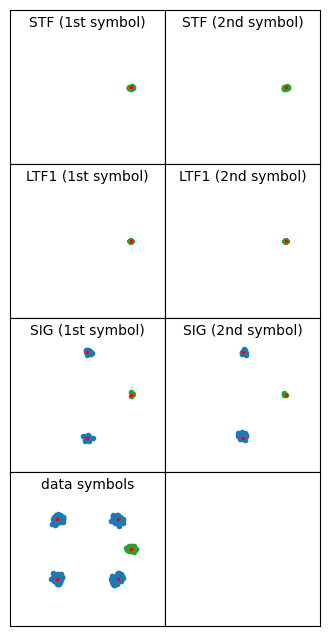

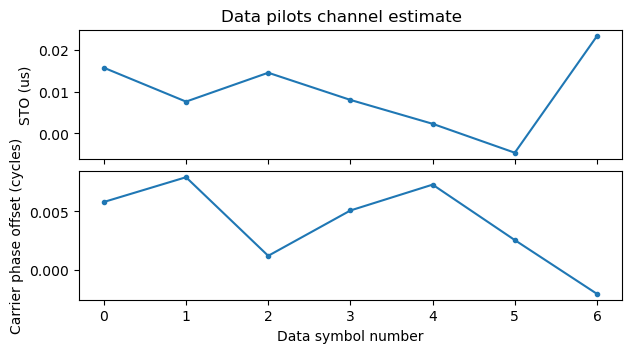

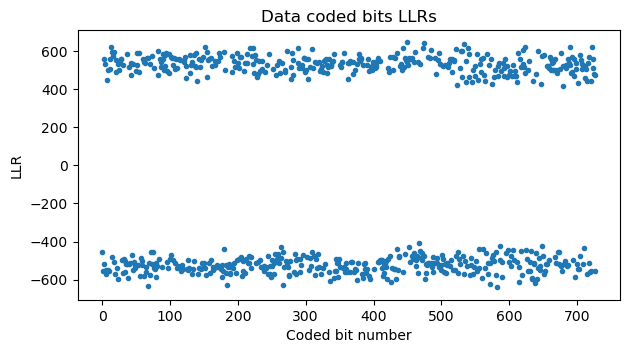

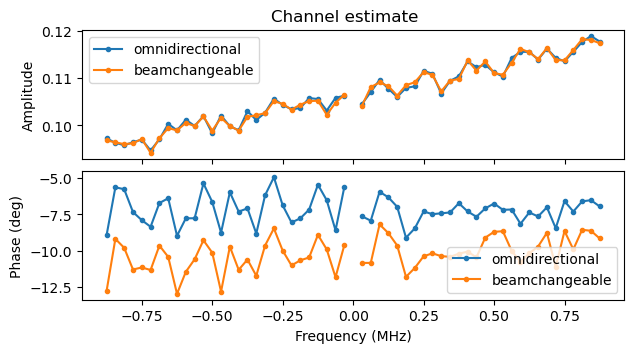

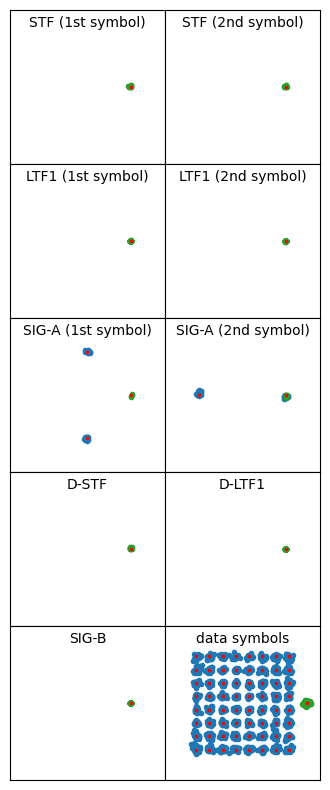

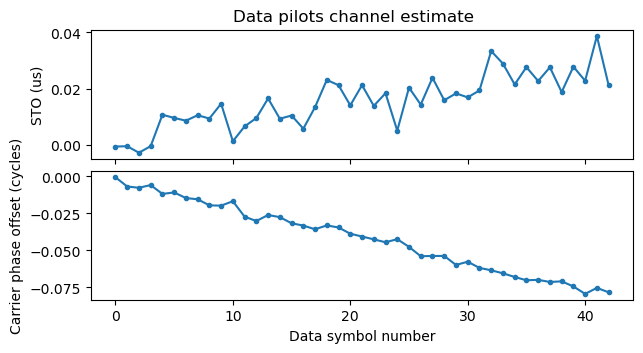

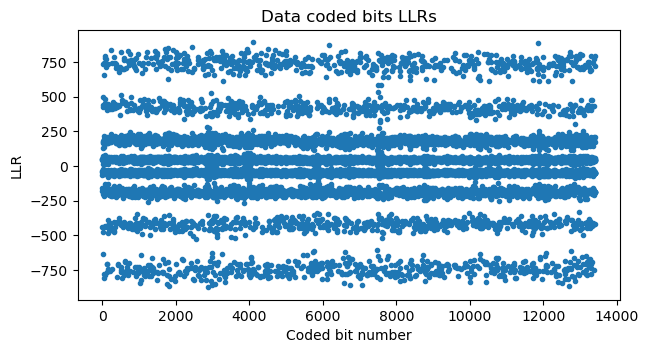

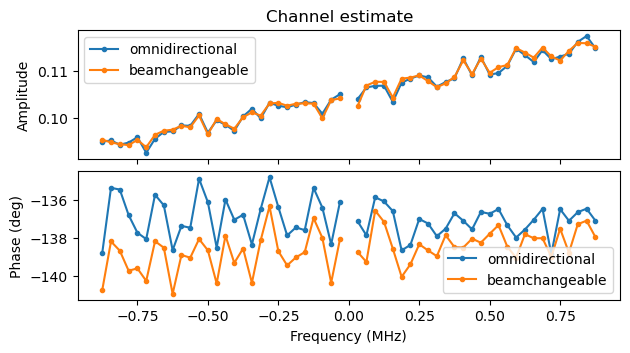

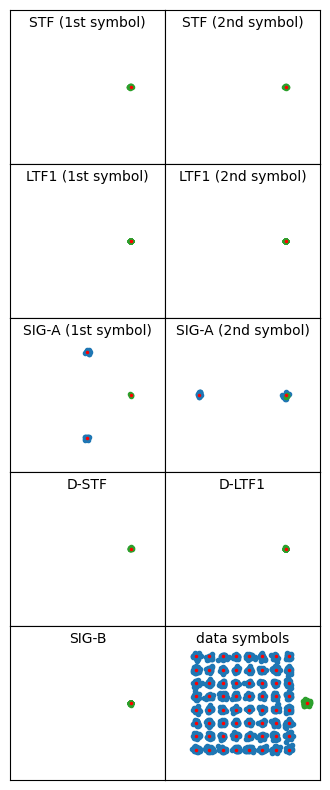

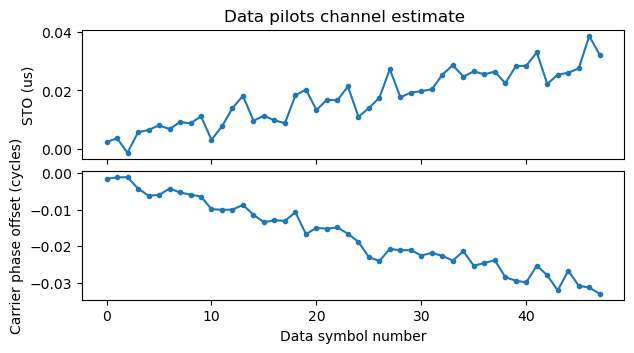

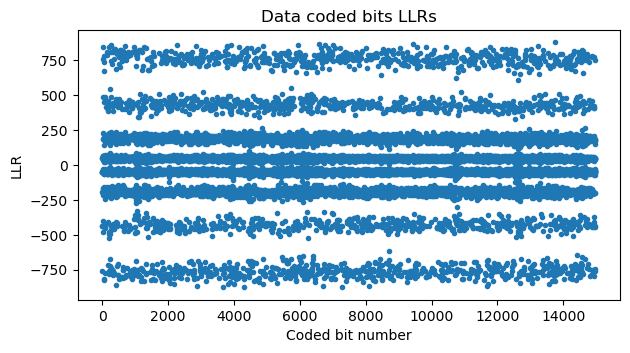

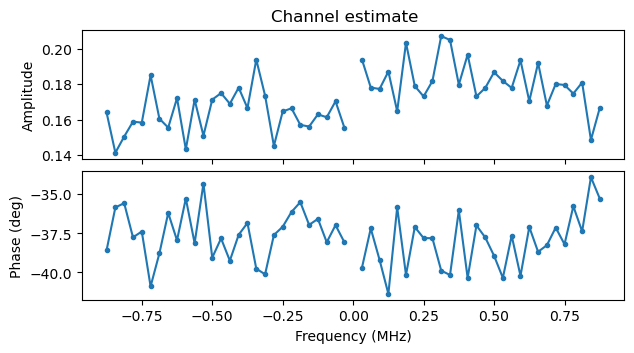

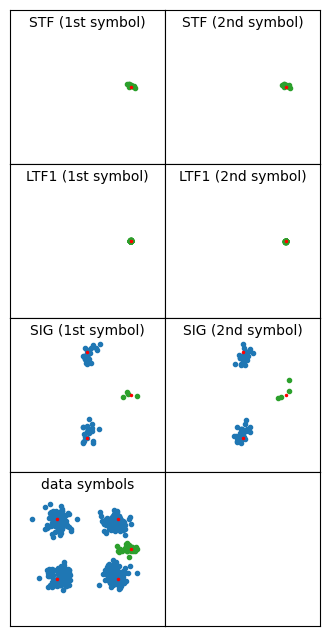

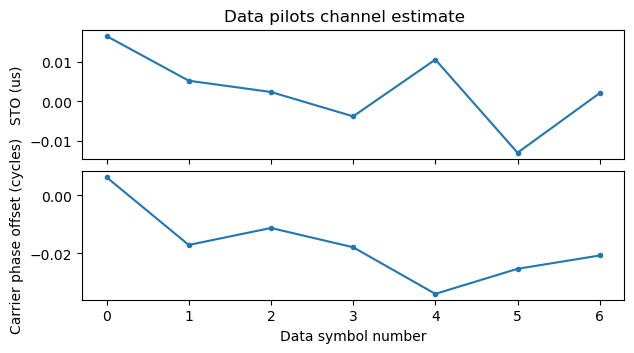

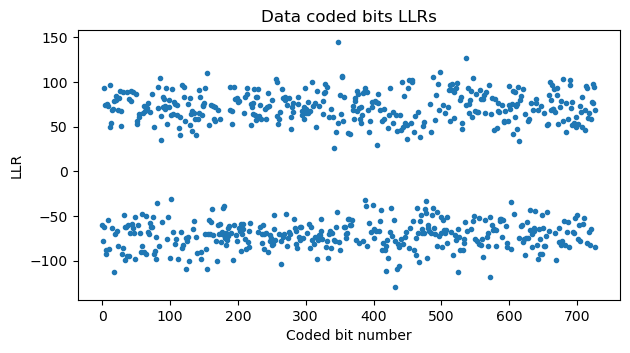

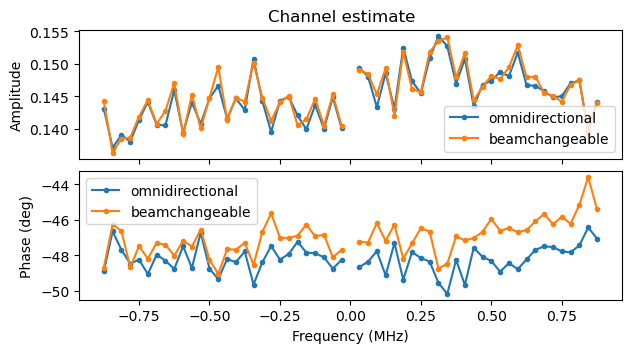

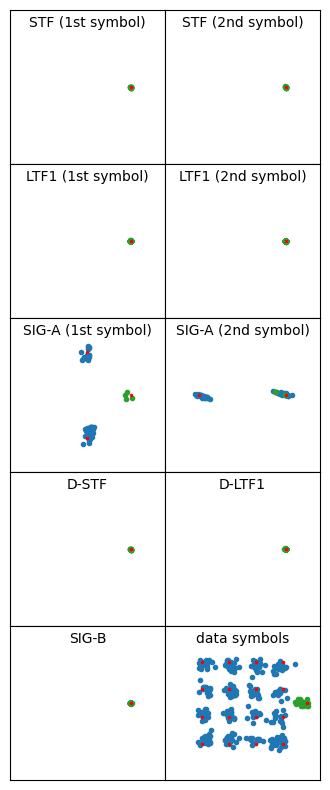

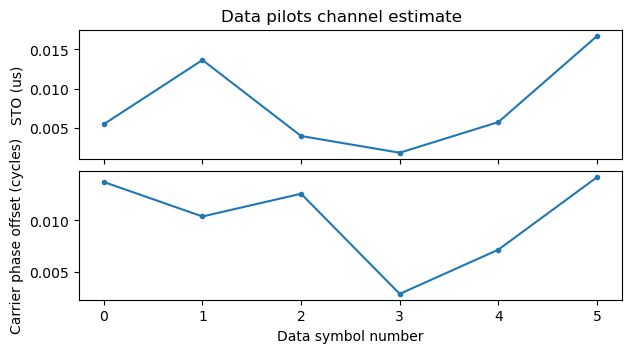

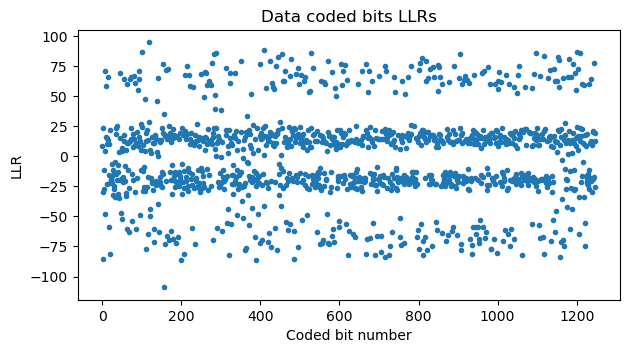

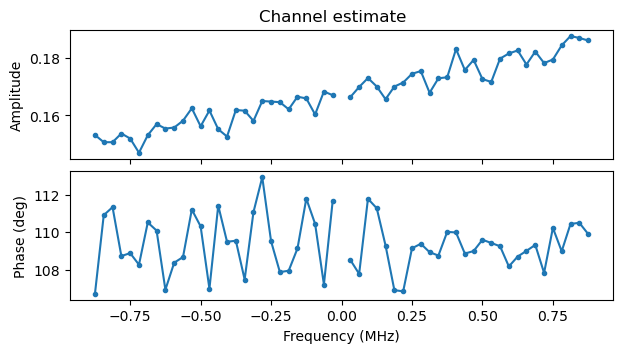

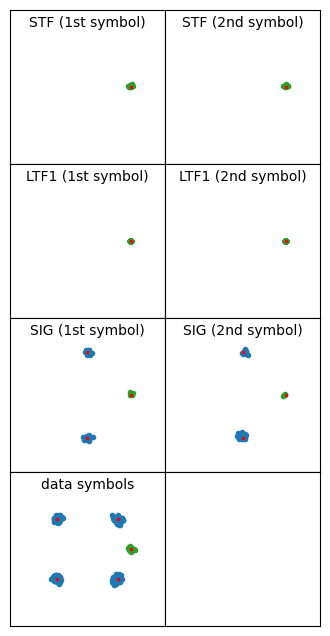

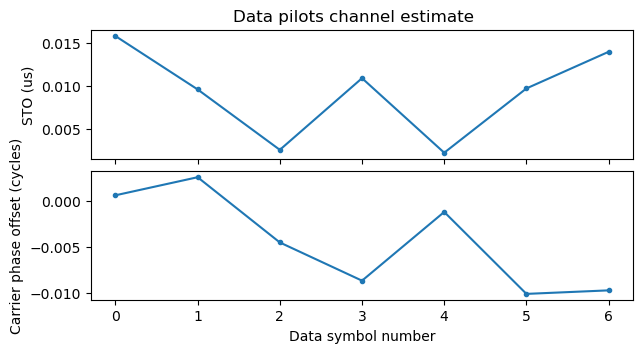

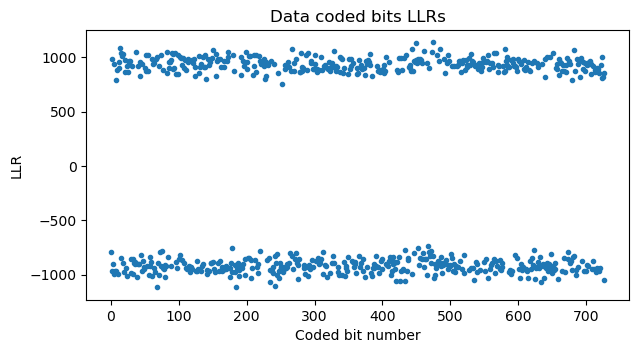

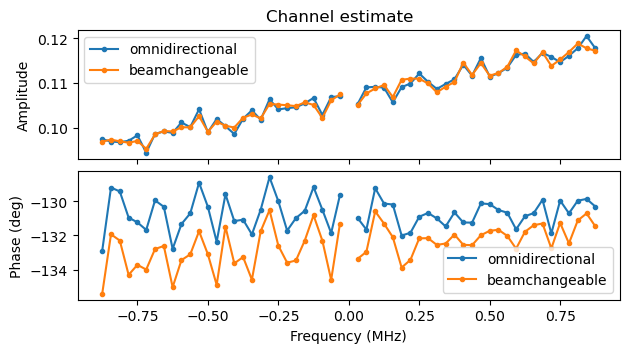

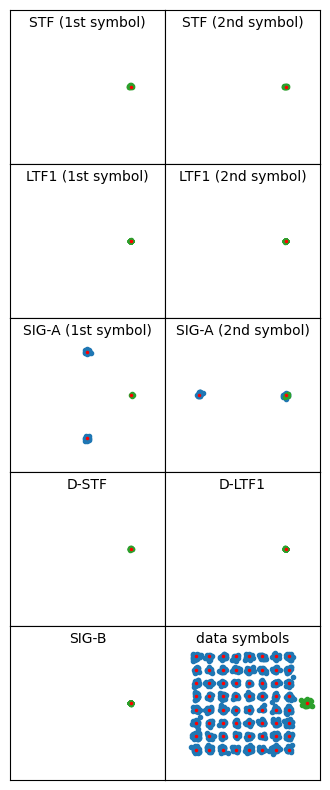

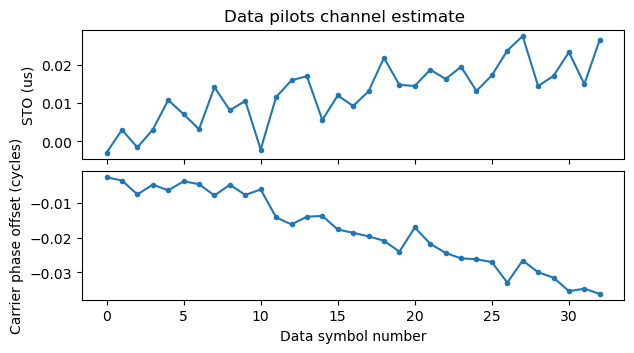

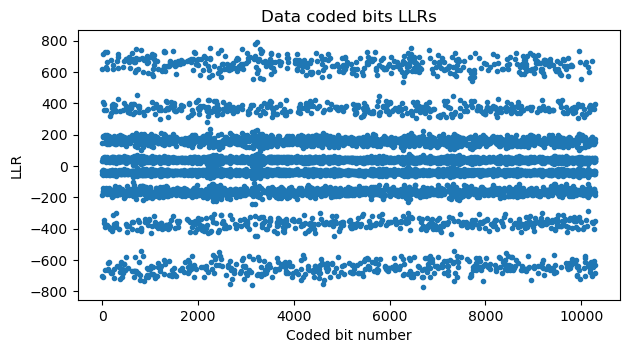

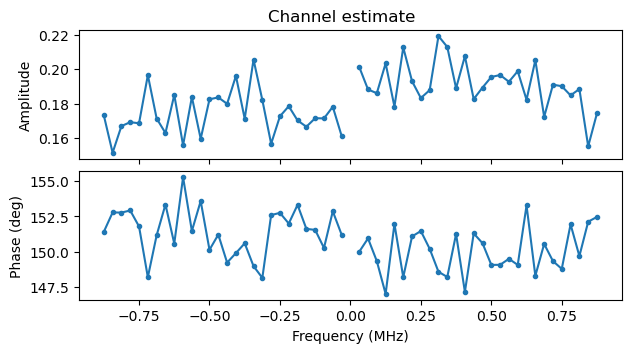

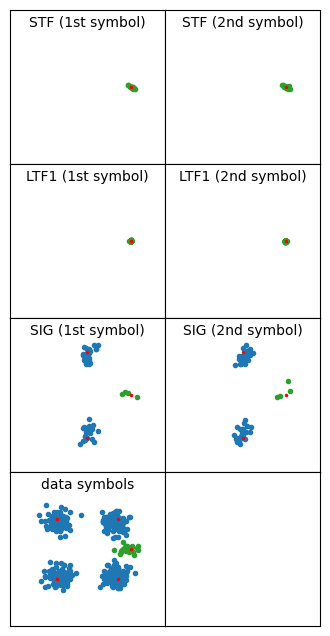

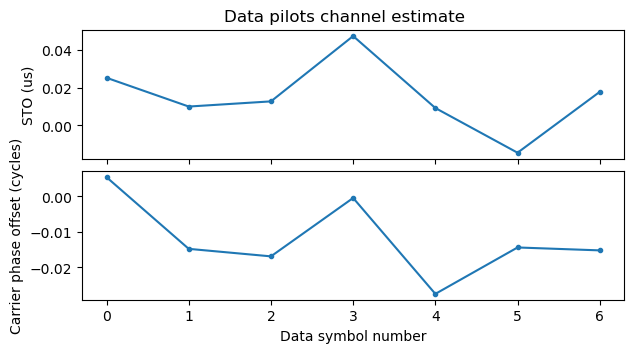

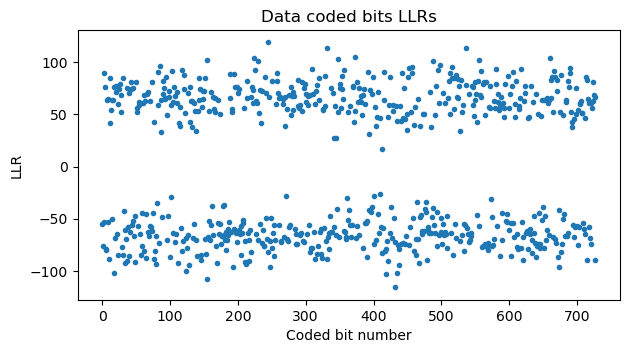

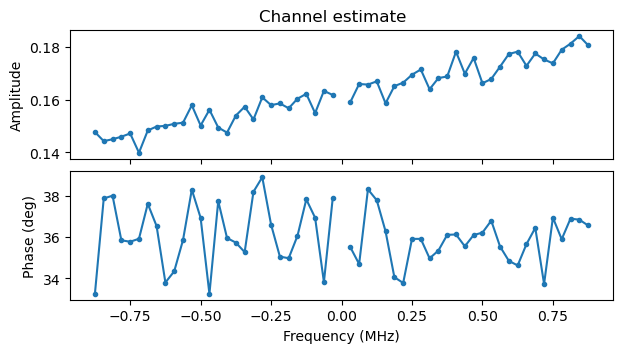

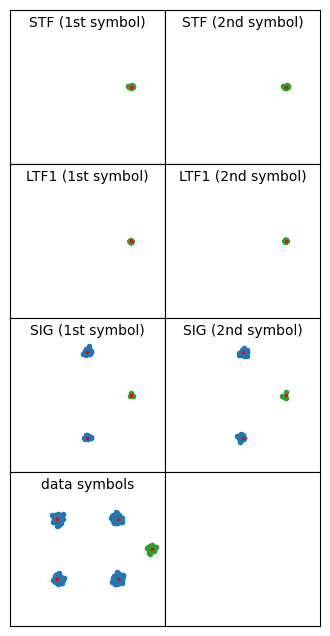

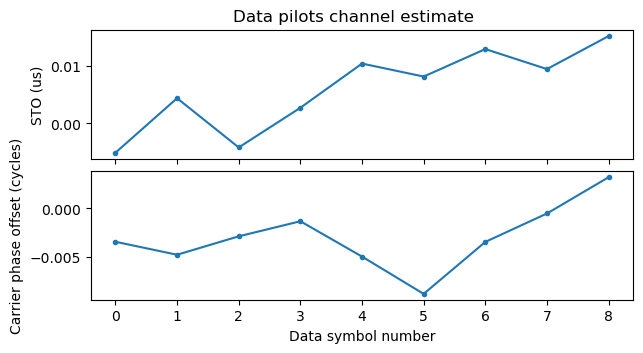

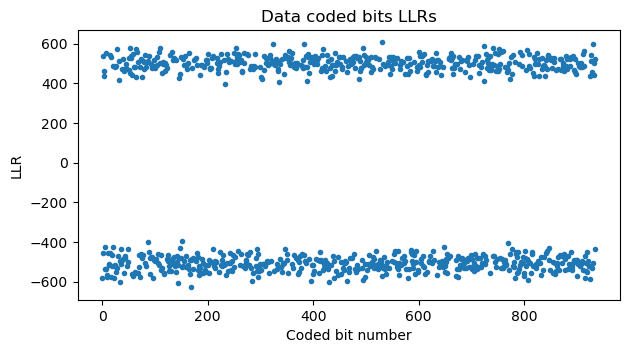

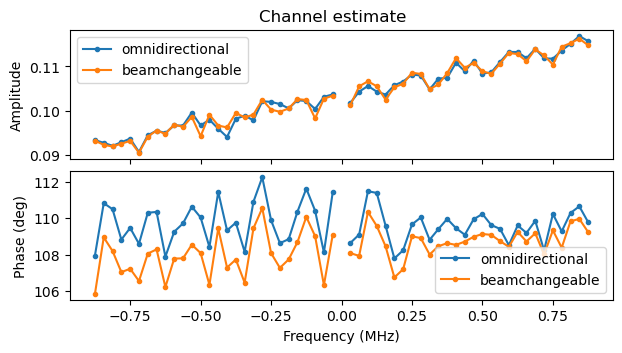

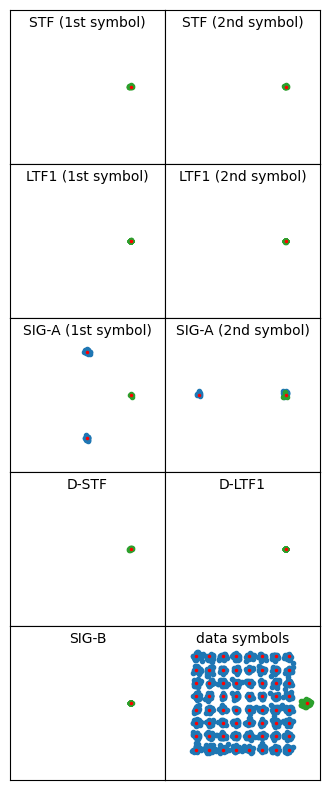

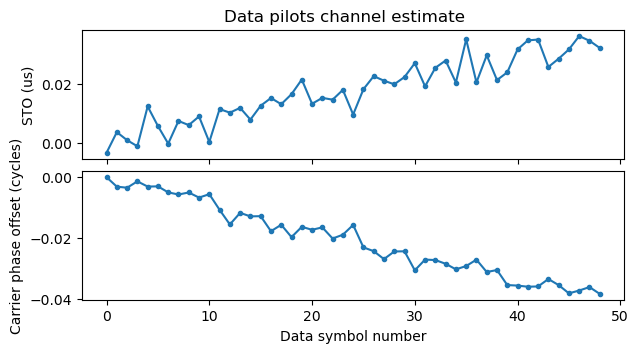

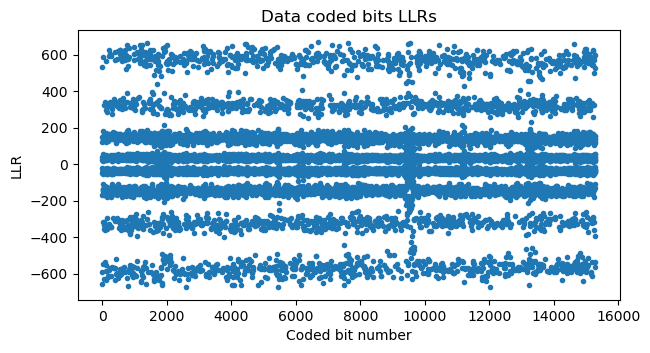

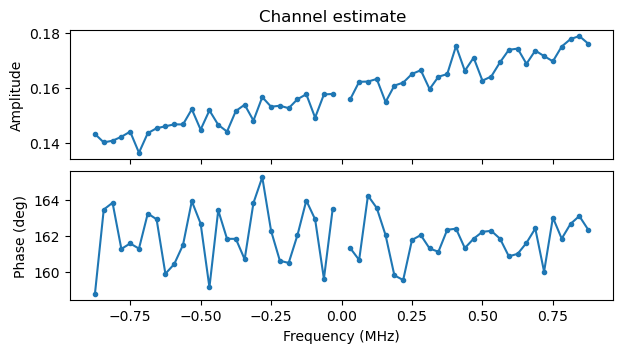

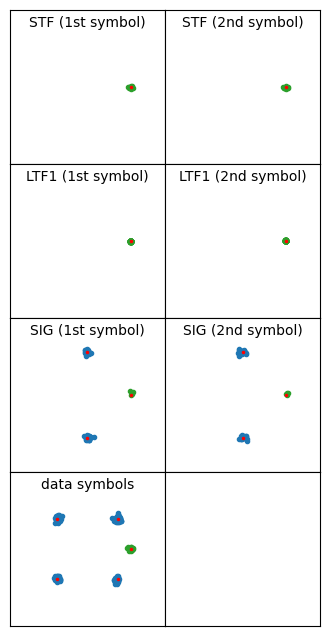

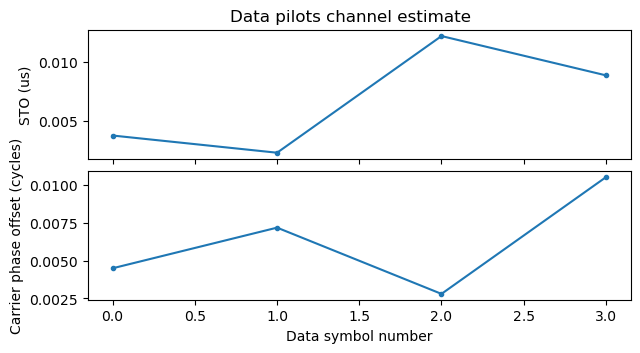

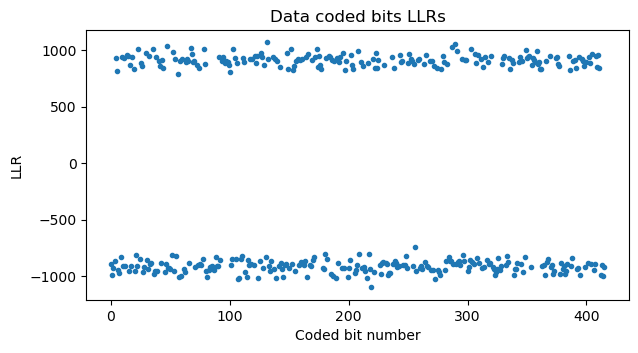

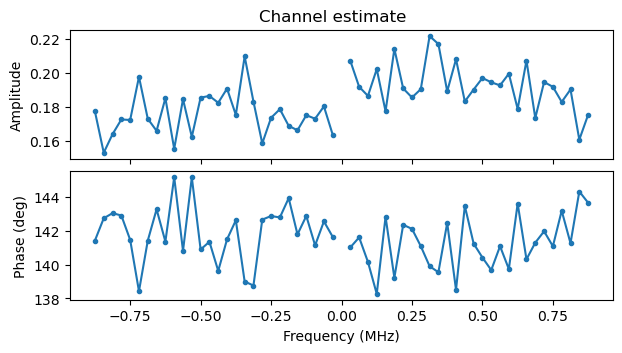

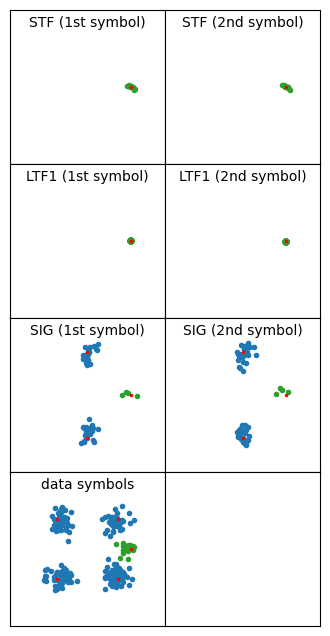

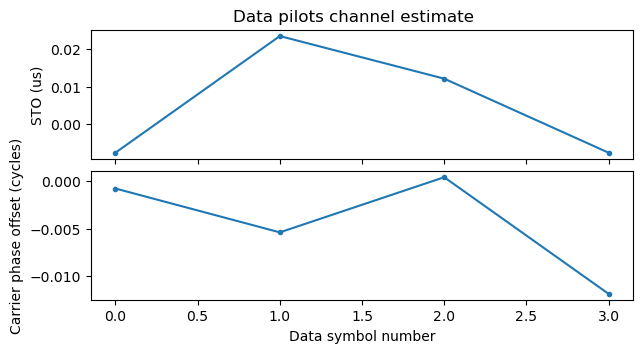

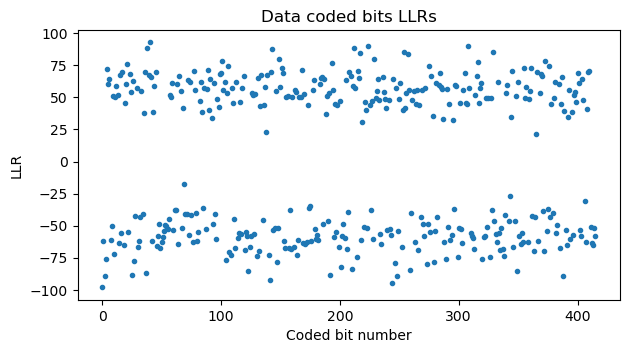

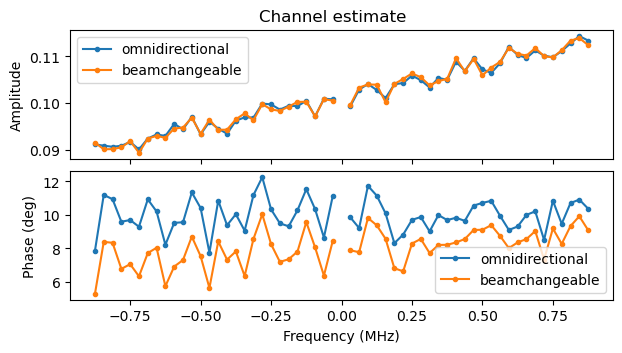

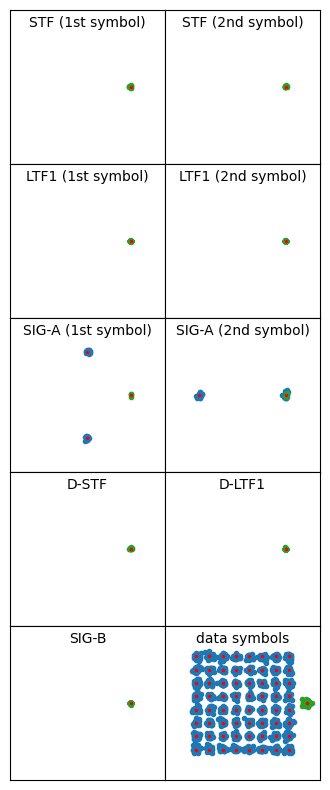

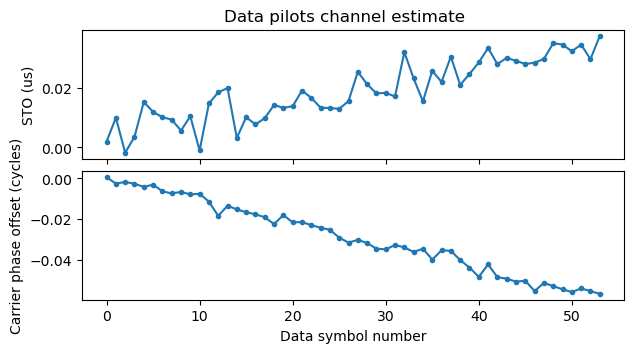

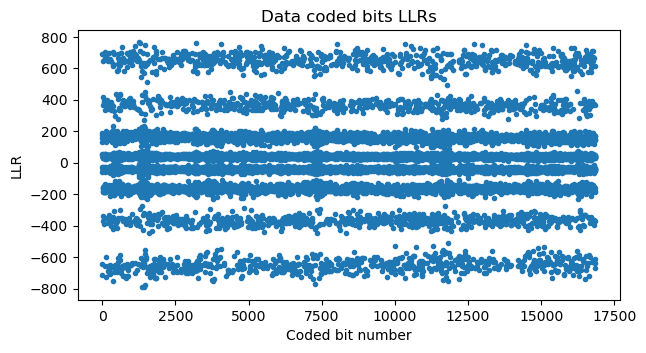

In [18]:
for n, start_idx in enumerate(max_idx[detections]):
    print(f'PPDU {n} at sample {start_idx}')
    print('-----------------------------')
    decode_ppdu(start_idx, plots=n < 16, verbose=True)
    print()

In [19]:
scapy.utils.wrpcap('802_11_ah.pcap', wireshark_packets)

Coarse CFO: 13424.289 Hz
Fine CFO: -47.574 Hz
Total CFO: 13376.716 Hz
Coarse STO: 0.00 samples
Fine STO: -0.749 samples
Total STO: -0.749 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 1
BW = 0
Nsts = 0
SIG ID = 0x121
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 386
response indication = 2
traveling pilots = 1

noise sigma = 0.047
BER = 0.00035704796067490365


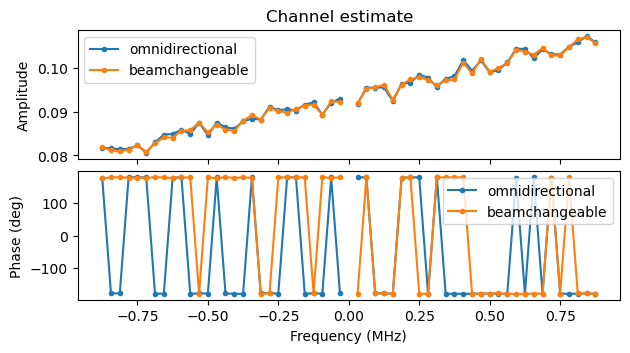

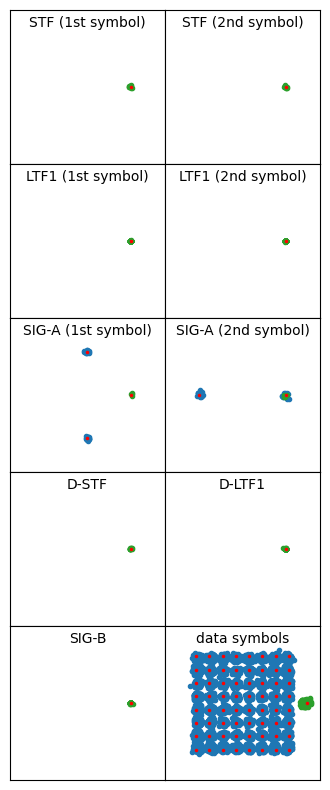

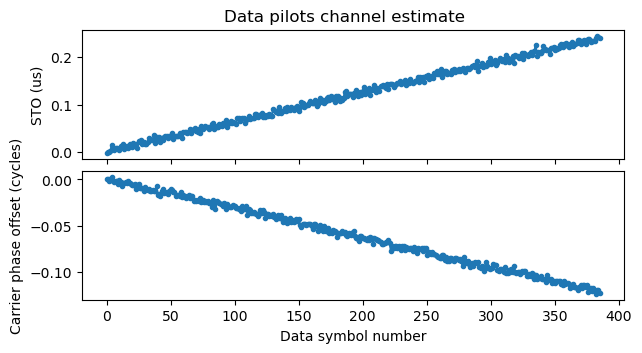

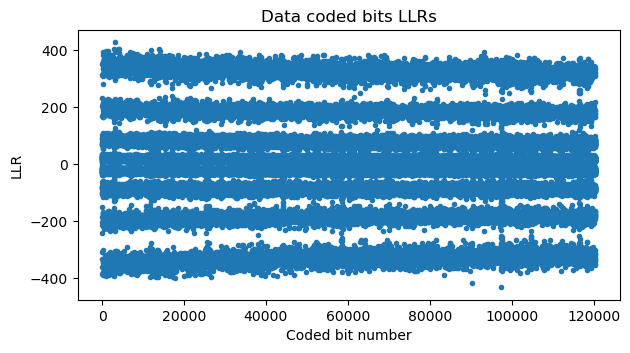

In [20]:
# Long PPDU
decode_ppdu(8476092, plots=True, verbose=True);

Coarse CFO: 11871.710 Hz
Fine CFO: 14.882 Hz
Total CFO: 11886.592 Hz
Coarse STO: 0.00 samples
Fine STO: 1.138 samples
Total STO: 1.138 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 1
coding = BCC
LDPC extra = 1
MCS = 7 (64-QAM 5/6)
beam change / smoothing = 0
aggregation = 1
length = 4
response indication = 2
traveling pilots = 1

noise sigma = 0.089
BER = 0.03766025641025641


/tmp/ipykernel_90718/3422983186.py:387: UserWarning: wrong FCS for MPDU (start_idx = 11087798)
  warnings.warn(f'wrong FCS for MPDU (start_idx = {start_idx})')


[b'\x08B\x00\x00\xda\xbd\x00v\xa50\xda\xbd\x00\x9ek\x90\xda\xbd\x00v\xa50\x90U\x0c\xe7\x00 v\x97\xc3$)\xe3y|\xc2:F\xc7{\xad_\xa3\x00O\x12\x01\xb7\x8f\x85\xdc\xb3\x8b\xc5A4u\x03\xbd\xdb\xd4\x9c^9\xdc\x96\xbcM\xf7\xe3c\xaa*\x93Y\xf0M\x0fzQ\xe1\x7f\xb7i\xb1\xc3A\xb8\x7f]\t`\xc4\x86\x16\xa7lYxZ\xc9\xb8O\x93\x08\xed\xe4\x92#x\xcb\xe9\xdb',
 b'',
 b'']

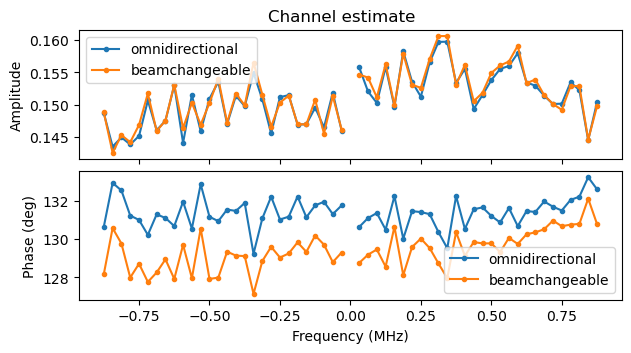

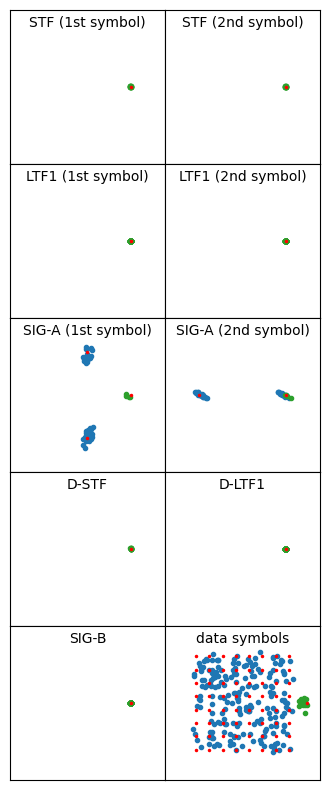

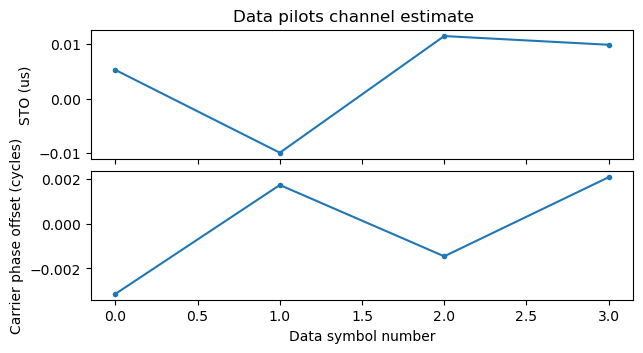

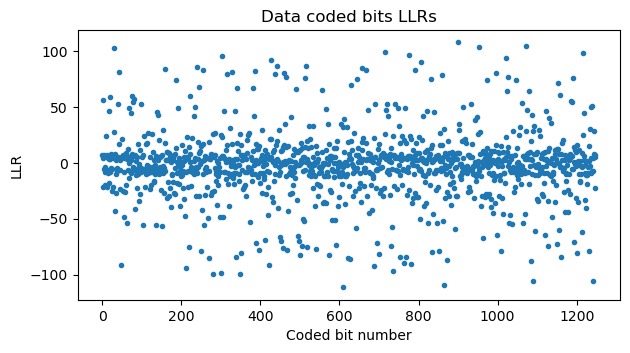

In [21]:
# Short GI PPDU (bad constellation; has some bit errors)
decode_ppdu(11087797, plots=True, verbose=True)

Coarse CFO: 11926.903 Hz
Fine CFO: -12.489 Hz
Total CFO: 11914.414 Hz
Coarse STO: -2.46 samples
Fine STO: 0.516 samples
Total STO: -1.945 samples

SIG-A contents
MU/SU = 0
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x109
short GI = 1
coding = BCC
LDPC extra = 1
MCS = 3 (16-QAM 1/2)
beam change / smoothing = 0
aggregation = 1
length = 10
response indication = 2
traveling pilots = 1

noise sigma = 0.130
BER = 0.0019230769230769232


[b'\x08B\x00\x00\xda\xbd\x00v\xa50\xda\xbd\x00\x9ek\x90\xda\xbd\x00v\xa50\x90U\x0c\xe7\x00 v\x97\x03\xb5\xff\x0c\ru\xaf\xde\x0e\xa2`t\xa5*\xf9\xd2\x98j\xe3CZ\x81p\x7f\x1b\x84\xc8t\x03\xbd\xdb\xd4\x9c^9\xdc\x96\xbcM\xf7\xe3c\xaa*\x93Y\xf0M\x0fzQ\xe1\x7f\xb7i\xb1\xc3A\xb8\x7f]\t`\xc4\x86\x96\x93lYxpW\x88\xe8(NE.\xd45\xff\xf2\xbbr',
 b'',
 b'']

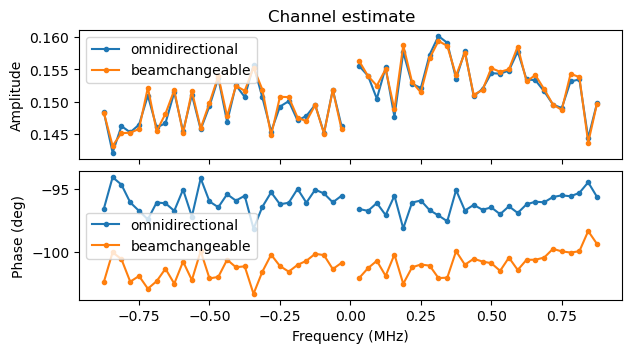

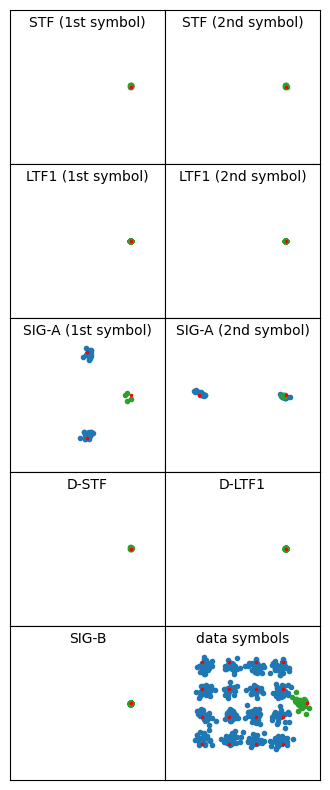

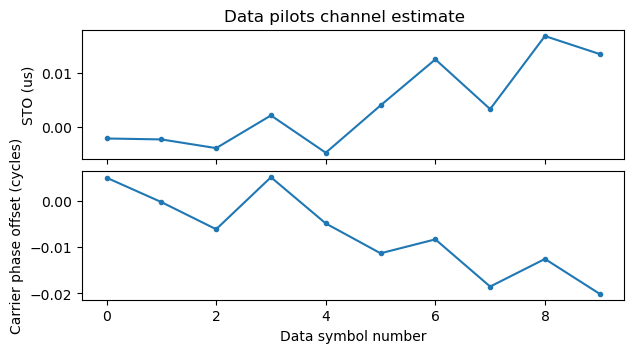

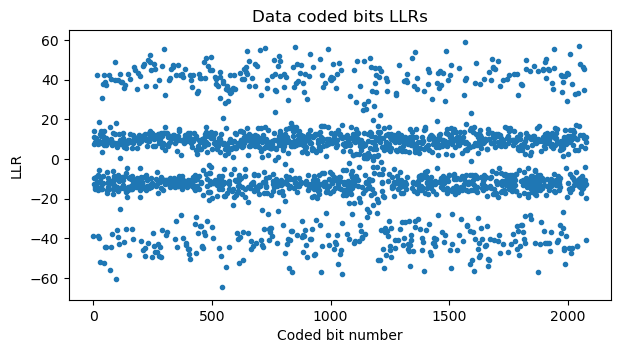

In [22]:
# Retransmission (same SN, but retry flag not set) with lower MCS
# Still not great constellation, but can be decoded
decode_ppdu(11093664, plots=True, verbose=True)

Coarse CFO: 11784.394 Hz
Fine CFO: 368.971 Hz
Total CFO: 12153.364 Hz
Coarse STO: 0.00 samples
Fine STO: 0.203 samples
Total STO: 0.203 samples

SIG contents
STBC = 0
uplink indication = 0
BW = 0
Nsts = 0
SIG ID = 0x001
short GI = 0
coding = BCC
LDPC extra = 1
MCS = 1 (QPSK 1/2)
smoothing = 0
aggregation = 0
length = 40 (N_sym = 7)
response indication = 0
traveling pilots = 0
NDP indication = 0

noise sigma = 0.213
BER = 0.009615384615384616


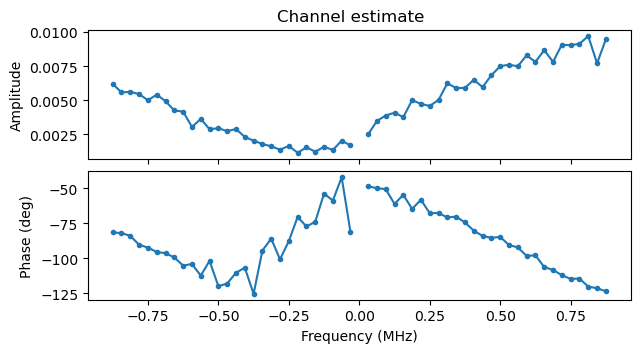

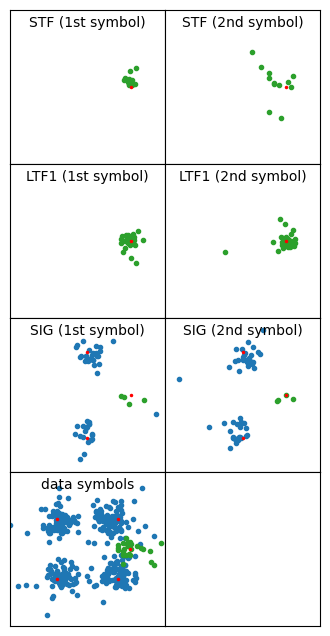

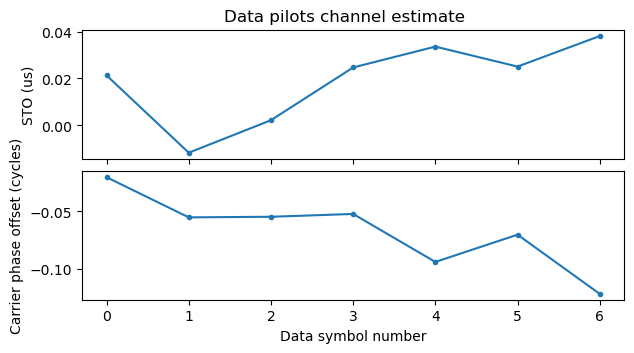

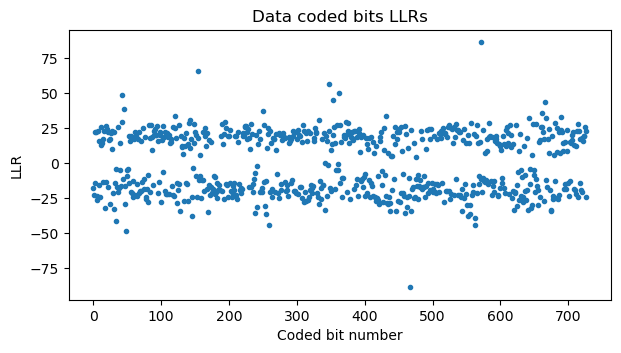

In [23]:
# fading in the monitor screen signal
decode_ppdu(131510715, plots=True, verbose=True);